In [1]:
import numpy as np
import tensorflow as tf
import gym
import cv2 as cv
import matplotlib.pyplot as plt
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline


/home/ninja/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Testing Environment

Shape =  (210, 160, 3)
Action space size: Action  4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


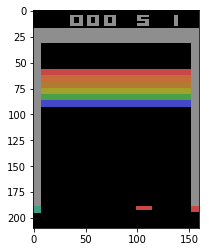

In [3]:
env = gym.make('BreakoutDeterministic-v4')

frame = env.reset()
plt.figure()
plt.imshow(frame)

totalActions = env.action_space.n
# startE = 1.0
# endE = 0.1
# e = startE
# anneling_steps = 10000

print("Shape = ",frame.shape)
print("Action space size: Action  {}".format(totalActions))
print(env.unwrapped.get_action_meanings())
# env.render()

# is_done = False

# while not is_done:
#     frame, reward, is_done, _ = env.step(env.action_space.sample())  
#     env.render()
env.close()

# Preprocessing the input state

In [4]:
def preprocess(img):
    grayImg = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    resized = cv.resize(grayImg,(84,110))
    preProcessedImg = resized[:84,:84]
    
    return preProcessedImg
    
    #return preProcessedImg,resized

(84, 84) uint8


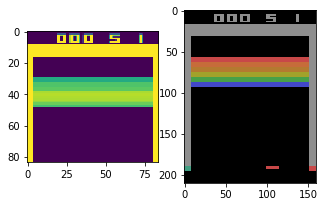

In [5]:
fig = plt.figure(figsize=(8,8))
newFrame = preprocess(frame)
print(newFrame.shape,newFrame.dtype)
fig.add_subplot(1,3,1)
plt.imshow(newFrame)
#fig.add_subplot(1,3,3)
#plt.imshow(ngray)
fig.add_subplot(1,3,2)
plt.imshow(frame)
plt.show()

# Deep Q Model 

In [6]:
class atariAgent():
    """ Atari Agent contains the model and functions to predict and train the agent"""
    def __init__(self,totalActions,scope = "agent"):
        self.scope = scope
        self.totalActions = totalActions
        with tf.variable_scope(self.scope):
            self.QModel()
    
    def QModel(self):
        """Contains the model"""
        self.Xin = tf.placeholder(shape=[None,84,84,4],dtype=tf.uint8,name='Xin')
        self.y = tf.placeholder(shape=[None],dtype=tf.float32,name='yin')
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32,name='actions')
        
        X = tf.to_float(self.Xin) / 255.0
        
        #model starts
        conv1 = tf.contrib.layers.conv2d(X,16,8,4,activation_fn=tf.nn.relu)
        
        conv2 = tf.contrib.layers.conv2d(conv1,32,4,2,activation_fn=tf.nn.relu)
        
        convOut = tf.contrib.layers.flatten(conv2)
        fc1 = tf.contrib.layers.fully_connected(convOut,256,activation_fn=tf.nn.relu)
        self.QValues = tf.contrib.layers.fully_connected(fc1,self.totalActions,activation_fn=None)
        
        batchSize = tf.shape(self.Xin)[0]
        yIndices = tf.range(batchSize) * self.totalActions + self.actions
        self.predictedActions = tf.gather(tf.reshape(self.QValues,[-1]),yIndices)
        
        #calculates loss function
        self.losses = tf.squared_difference(self.y, self.predictedActions)
        self.loss = tf.reduce_mean(self.losses)
        
        #training step
        self.optimizer = tf.train.RMSPropOptimizer(0.00025,0.99)
        self.trainStep = self.optimizer.minimize(self.loss, global_step=tf.train.get_global_step())
        
        
    def play(self,sess,states):
        """runs the model for the given state and predicts the Q values"""
        return sess.run(self.QValues,{self.Xin : states})
        
    def train(self,sess,states,y,actions):
        """Trains the Agent on the given input and target values and returns the loss
        """
        feed_dict = { self.Xin: states, self.y: y, self.actions: actions }
        loss, _ = sess.run([self.loss, self.trainStep],feed_dict)
        
        return loss
    
    

# Fill Experience Replay memory

In [15]:
from collections import namedtuple,deque

def initExperienceReplay(env,initReplaySize,cell):
    replayBuffer = deque()
    state = env.reset()
    state = preprocess(state)
    state = np.stack([state]*4,axis=2)
    print("Filling Experience memory of the agent")
    for i in range(initReplaySize):
        action = env.action_space.sample()
        nextState, reward, isDone, _ = env.step(action)
        nextState = preprocess(nextState)
        nextState = np.append(state[:,:,1:],nextState[:,:,np.newaxis],axis=2)
        replayBuffer.append(cell(state,reward,action,nextState,isDone))
        if(isDone):
            state = env.reset()
            state = preprocess(state)
            state = np.stack([state]*4,axis=2)
        else:
            state = nextState
    
    env.close()
    print("Filled memory of size {}".format(len(replayBuffer)))       
    return replayBuffer

#cell = namedtuple("cell","state reward action nextState isDone")
#buff = initExperienceReplay(env,200,cell)
#print(len(buff))
#print(buff[25].reward)

# Policy algorithm

In [8]:
def EGreedyPolicy(epsilon,QValues):
    numActions = QValues.shape[1]
    probs = np.ones(numActions, dtype=float) * epsilon / numActions
    best_action = np.argmax(QValues)
    
    probs[best_action] += (1.0 - epsilon)
    #print(probs)
    optimizedAction = np.random.choice(numActions,p=probs)
    return optimizedAction
#QValues = np.random.randn(4)
#print(QValues)
#print(EGreedyPolicy(0.7,QValues))

# Model parameters copier

In [9]:
def copyParameters(sess,targetModel,QModel):
    params1 = [var for var in tf.trainable_variables() if var.name.startswith(targetModel.scope)]
    params1 = sorted(params1,key=lambda var: var.name)
    params2 = [var for var in tf.trainable_variables() if var.name.startswith(QModel.scope)]
    params2 = sorted(params2,key=lambda var: var.name)
    copies = []
    for p1,p2 in zip(params1,params2):
        copy = p1.assign(p2)
        copies.append(copy)
    sess.run(copies)

In [21]:
#some values
numEpisodes = 100
initReplaySize = 5000
replaySize = 10000
batchSize = 32
startE = 1.0
endE = 0.1
annealingSteps = 5000
copyFrequency = 10000
videoFrequency = 5000
discountFactor = 0.99
checkpointDir = "checkpoint"
monitorDir = "monitor"

In [22]:
#import random
from gym.wrappers import Monitor


def trainAgent():
    #start environment
    env = gym.make('BreakoutDeterministic-v4')
    
    totalActions = env.action_space.n
    
    tf.reset_default_graph()
    
    targetModel = atariAgent(totalActions,scope="targetModel")
    QModel = atariAgent(totalActions,scope="QModel")
    
    if not os.path.exists(checkpointDir):
        os.makedirs(checkpointDir)
    if not os.path.exists(monitorDir):
        os.makedirs(monitorDir)
        
    checkpoint = os.path.join(checkpointDir,"model")
    monitor = os.path.join(monitorDir,"game")
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        
        env = Monitor(env, directory=monitor, video_callable=lambda totalStep: totalStep % \
                      videoFrequency == 0, resume=True)
        
        state = env.reset()
        
        ckpt = tf.train.latest_checkpoint(checkpointDir)
        if ckpt:
            saver.restore(sess,ckpt)
            totalStep = 0
            print("Existing checkpoint {} restored...".format(ckpt))
        else:
            totalStep = 0
            
        cell = namedtuple("cell","state reward action nextState isDone")
        
        replayMemory = initExperienceReplay(env,initReplaySize,cell)
        
        epsilonValues = np.linspace(startE,endE,num=annealingSteps)
        
        
        
        episodeLengths = []
        episodeRewards = []
        
        for episode in range(numEpisodes):
            state = env.reset()
            state = preprocess(state)
            state = np.stack([state] * 4, axis=2)
            
            loss = None
            episodeLength = 0
            
            while(True):
                if(totalStep%copyFrequency == 0):
                    copyParameters(sess,targetModel,QModel)
                    print("Target Model updated...")

                
                epsilon = epsilonValues[min(totalStep, annealingSteps-1)]
                QValues = QModel.play(sess,np.expand_dims(state,0))
                bestAction = EGreedyPolicy(epsilon,QValues)

                nextState,reward,isDone,_ = env.step(bestAction)
                nextState = preprocess(nextState)
                #nextState = np.stack([nextState] * 4,axis=2)
                nextState = np.append(state[:,:,1:],nextState[:,:,np.newaxis],axis=2)
                
                if(len(replayMemory) == replaySize):
                    replayMemory.popleft()
                
                replayMemory.append(cell(state,reward,bestAction,nextState,isDone))

                indices = np.random.choice(len(replayMemory)-1,batchSize,replace=False)
                batch = [replayMemory[i] for i in indices]
                #batch = random.sample(replayMemory, batchSize)
                states,rewards,actions,nextStates,isDones = map(np.array,zip(*batch))
                
                #targetmodel prediction
                tQValues = targetModel.play(sess,nextStates)
                targetY = rewards + (1 - isDones) * discountFactor * np.amax(tQValues,axis=1)

                #gradient descent step
                loss = QModel.train(sess,states,targetY,actions)
                episodeLength += 1
                totalStep += 1
                
                if(isDone):
                    episodeRewards.append(reward)
                    episodeLengths.append(episodeLength)
                    print("Episode {} Stats:\n\tGlobal step: {} Final reward: {} episode length: {} loss: {}\n"\
                          .format(episode,totalStep,reward,episodeLength,loss))
                    
                    saver.save(tf.get_default_session(), checkpoint)
                    break
                    
                else:
                    state = nextState
                    totalStep += 1
                    #print("Loss: {}, reward: {}".format(loss,reward))

                    

In [23]:
trainAgent()

/home/ninja/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from checkpoint/model
Existing checkpoint checkpoint/model restored...
Filling Experience memory of the agent
Filled memory of size 5000
Target Model updated...
Loss: 0.0005017169751226902, reward: 0.0
Loss: 0.004014074802398682, reward: 0.0
Loss: 0.0002699611650314182, reward: 0.0
Loss: 0.0050192419439554214, reward: 0.0
Loss: 0.014619404450058937, reward: 0.0
Loss: 0.024873238056898117, reward: 0.0
Loss: 0.0047758230939507484, reward: 0.0
Loss: 0.0008043142152018845, reward: 0.0
Loss: 0.0024837180972099304, reward: 0.0
Loss: 0.006028691306710243, reward: 0.0
Loss: 0.005355950444936752, reward: 0.0
Loss: 0.0002309905830770731, reward: 0.0
Loss: 0.008754865266382694, reward: 0.0
Loss: 0.03335685282945633, reward: 0.0
Loss: 0.009260398335754871, reward: 0.0
Loss: 0.002126231323927641, reward: 0.0
Loss: 0.0004780134477186948, reward: 0.0
Loss: 0.02488991990685463, reward: 0.0
Loss: 0.0007468442199751735, reward: 0.0
Loss: 0.0005599688156507909, reward

Loss: 0.012065236456692219, reward: 0.0
Loss: 0.05179581046104431, reward: 0.0
Loss: 0.007580370642244816, reward: 0.0
Loss: 0.0006115043070167303, reward: 0.0
Loss: 0.0026515787467360497, reward: 0.0
Loss: 0.0005243377527222037, reward: 0.0
Loss: 0.0014325818046927452, reward: 0.0
Loss: 0.0001336318819085136, reward: 0.0
Loss: 0.0013127124402672052, reward: 0.0
Loss: 0.000205811535124667, reward: 0.0
Loss: 0.0004988096770830452, reward: 0.0
Loss: 0.000331421586452052, reward: 0.0
Loss: 0.00028448173543438315, reward: 0.0
Loss: 0.033036306500434875, reward: 0.0
Loss: 0.0026974533684551716, reward: 0.0
Loss: 0.003119590226560831, reward: 0.0
Loss: 0.0003531841794028878, reward: 0.0
Loss: 0.0002728570834733546, reward: 0.0
Loss: 0.001319327624514699, reward: 0.0
Loss: 0.0008296594605781138, reward: 0.0
Loss: 0.0015939115546643734, reward: 0.0
Loss: 0.00036286766408011317, reward: 0.0
Loss: 0.0001245145540451631, reward: 0.0
Loss: 0.00033283716766163707, reward: 0.0
Loss: 0.00448640296235

Loss: 0.00023371735005639493, reward: 0.0
Loss: 0.002063606632873416, reward: 0.0
Loss: 0.0001626443408895284, reward: 0.0
Loss: 0.0005581676959991455, reward: 0.0
Loss: 0.06212973967194557, reward: 0.0
Loss: 0.007119347807019949, reward: 0.0
Loss: 0.0019786208868026733, reward: 0.0
Loss: 0.00013088372361380607, reward: 0.0
Loss: 0.04953497275710106, reward: 0.0
Loss: 0.0015120479511097074, reward: 0.0
Loss: 0.00021703442325815558, reward: 0.0
Loss: 0.0002786098630167544, reward: 0.0
Loss: 0.00024177930026780814, reward: 0.0
Loss: 0.00039865821599960327, reward: 0.0
Loss: 0.00568631524220109, reward: 0.0
Loss: 0.012373910285532475, reward: 0.0
Loss: 0.0033717676997184753, reward: 0.0
Loss: 0.000512571248691529, reward: 0.0
Loss: 0.002100816462188959, reward: 0.0
Loss: 0.0001150700991274789, reward: 0.0
Loss: 0.001491125556640327, reward: 0.0
Loss: 0.02803153730928898, reward: 0.0
Loss: 0.0006094070849940181, reward: 0.0
Loss: 0.002443422796204686, reward: 0.0
Loss: 0.000315220037009567

Loss: 8.620047447038814e-05, reward: 0.0
Loss: 0.0032838748302310705, reward: 0.0
Loss: 0.00015986550715751946, reward: 0.0
Loss: 0.0006012177909724414, reward: 0.0
Loss: 0.0004545017727650702, reward: 0.0
Loss: 0.00027980978484265506, reward: 0.0
Loss: 6.432605732697994e-05, reward: 0.0
Loss: 0.0005601411685347557, reward: 0.0
Loss: 8.066029113251716e-05, reward: 0.0
Loss: 0.00015735963825136423, reward: 0.0
Loss: 0.0004618518578354269, reward: 0.0
Loss: 0.005382627714425325, reward: 0.0
Loss: 0.00028436369029805064, reward: 0.0
Loss: 0.0002983962476719171, reward: 0.0
Loss: 0.002335501369088888, reward: 0.0
Loss: 0.002697564195841551, reward: 0.0
Loss: 0.004841095767915249, reward: 0.0
Loss: 0.001725418958812952, reward: 0.0
Loss: 0.00419663405045867, reward: 0.0
Loss: 0.0019682112615555525, reward: 0.0
Loss: 0.00017579662380740047, reward: 0.0
Loss: 0.001558447489514947, reward: 0.0
Loss: 0.0007328597130253911, reward: 0.0
Loss: 0.00015039149730000645, reward: 1.0
Loss: 0.0001244496

Loss: 0.0002633812837302685, reward: 0.0
Loss: 0.0025218792725354433, reward: 0.0
Loss: 0.0008323339279741049, reward: 0.0
Loss: 0.0029190662316977978, reward: 0.0
Loss: 0.00028244941495358944, reward: 0.0
Loss: 0.0001531766029074788, reward: 0.0
Loss: 0.015117604285478592, reward: 0.0
Loss: 0.0009301856625825167, reward: 0.0
Loss: 0.0004884692607447505, reward: 0.0
Loss: 0.00038400915218517184, reward: 0.0
Loss: 0.00102988351136446, reward: 0.0
Loss: 0.003688149619847536, reward: 0.0
Loss: 0.0005488671013154089, reward: 0.0
Loss: 0.00025222403928637505, reward: 0.0
Loss: 0.00025692276540212333, reward: 0.0
Loss: 0.006256538443267345, reward: 0.0
Loss: 0.0010799928568303585, reward: 0.0
Loss: 0.031008418649435043, reward: 0.0
Loss: 0.003670566249638796, reward: 0.0
Loss: 0.0014770989073440433, reward: 0.0
Loss: 0.00012464910105336457, reward: 0.0
Loss: 0.0020049072336405516, reward: 0.0
Loss: 0.0006872863741591573, reward: 0.0
Loss: 0.0001260141289094463, reward: 0.0
Loss: 0.0007265844

Loss: 0.00025166867999359965, reward: 0.0
Loss: 0.0015557340811938047, reward: 0.0
Loss: 0.0017444957047700882, reward: 0.0
Loss: 0.0024383601266890764, reward: 0.0
Loss: 0.00019382592290639877, reward: 0.0
Loss: 0.0007129922159947455, reward: 0.0
Loss: 9.071802196558565e-05, reward: 0.0
Loss: 6.954107811907306e-05, reward: 0.0
Loss: 0.00028733431827276945, reward: 0.0
Loss: 0.0004917205078527331, reward: 0.0
Loss: 0.00023751950357109308, reward: 0.0
Loss: 0.004068807698786259, reward: 0.0
Loss: 0.00218187109567225, reward: 0.0
Loss: 0.002034727018326521, reward: 0.0
Loss: 0.020303305238485336, reward: 0.0
Loss: 0.0003875766124110669, reward: 0.0
Loss: 0.00010736183321569115, reward: 0.0
Loss: 0.0007088457932695746, reward: 0.0
Loss: 0.0003551351255737245, reward: 0.0
Loss: 0.010108673013746738, reward: 0.0
Loss: 0.0003539585741236806, reward: 1.0
Loss: 0.0004646435263566673, reward: 0.0
Loss: 0.006457809824496508, reward: 0.0
Loss: 0.0020600748248398304, reward: 0.0
Loss: 0.0019534267

Loss: 0.0009610054548829794, reward: 0.0
Loss: 0.0011768876574933529, reward: 0.0
Loss: 0.0021351720206439495, reward: 0.0
Loss: 0.0010420740582048893, reward: 0.0
Loss: 0.007237470708787441, reward: 0.0
Loss: 0.0005851106834597886, reward: 0.0
Loss: 0.00021702554658986628, reward: 0.0
Loss: 0.00015494444232899696, reward: 0.0
Loss: 0.00015726337733212858, reward: 0.0
Loss: 0.0003321199328638613, reward: 0.0
Loss: 0.002219919813796878, reward: 0.0
Loss: 0.0024661701172590256, reward: 0.0
Loss: 0.002992674009874463, reward: 0.0
Loss: 0.001233656657859683, reward: 0.0
Loss: 0.0014069931348785758, reward: 0.0
Loss: 0.00016431542462669313, reward: 0.0
Loss: 0.0008932139026001096, reward: 0.0
Loss: 0.00011500250548124313, reward: 0.0
Loss: 0.00013033267168793827, reward: 0.0
Loss: 0.0021282911766320467, reward: 0.0
Loss: 0.00018063366587739438, reward: 0.0
Loss: 0.0026937839575111866, reward: 0.0
Loss: 0.0019431121181696653, reward: 0.0
Loss: 0.018430527299642563, reward: 0.0
Loss: 0.000506

Loss: 0.0007185792783275247, reward: 0.0
Loss: 0.001343581359833479, reward: 0.0
Loss: 0.0002585695474408567, reward: 0.0
Loss: 0.00010878864850383252, reward: 0.0
Loss: 0.000842065317556262, reward: 0.0
Loss: 0.0017410790314897895, reward: 0.0
Loss: 0.0002745671081356704, reward: 0.0
Loss: 0.00010607783769955859, reward: 0.0
Loss: 0.0003777911188080907, reward: 0.0
Loss: 0.00010628658492350951, reward: 0.0
Loss: 9.115668945014477e-05, reward: 0.0
Loss: 0.008611041121184826, reward: 0.0
Loss: 0.0007351129897870123, reward: 0.0
Loss: 0.00017144589219242334, reward: 0.0
Loss: 0.00036604568595066667, reward: 0.0
Loss: 0.011912466026842594, reward: 0.0
Loss: 0.02835635468363762, reward: 0.0
Loss: 0.004183883313089609, reward: 0.0
Loss: 0.0005517773679457605, reward: 0.0
Loss: 0.00043140724301338196, reward: 0.0
Loss: 0.0006705205305479467, reward: 0.0
Loss: 0.0004307625349611044, reward: 0.0
Loss: 0.005831349175423384, reward: 0.0
Loss: 0.000431497028330341, reward: 0.0
Loss: 0.00049527350

Loss: 0.0056267548352479935, reward: 0.0
Loss: 0.0010418517049401999, reward: 0.0
Loss: 0.00027652463177219033, reward: 0.0
Loss: 0.0002473797358106822, reward: 0.0
Loss: 0.00016590530867688358, reward: 0.0
Loss: 0.00020743912318721414, reward: 0.0
Loss: 0.016409480944275856, reward: 0.0
Loss: 0.0024844815488904715, reward: 0.0
Loss: 0.00016800918092485517, reward: 0.0
Loss: 0.0025142612867057323, reward: 0.0
Loss: 0.0024240256752818823, reward: 0.0
Loss: 0.08295517414808273, reward: 0.0
Loss: 0.01973801851272583, reward: 0.0
Loss: 0.009236988611519337, reward: 0.0
Loss: 0.0009912000969052315, reward: 0.0
Loss: 0.0002812705934047699, reward: 0.0
Loss: 0.0009713779436424375, reward: 0.0
Loss: 0.000170784056535922, reward: 0.0
Loss: 0.001310178660787642, reward: 0.0
Loss: 0.00034054176649078727, reward: 0.0
Loss: 0.002230053534731269, reward: 0.0
Loss: 0.00013099343050271273, reward: 0.0
Loss: 0.00116938934661448, reward: 0.0
Loss: 0.0001233639777638018, reward: 0.0
Loss: 0.0002067935129

Loss: 0.00011300122423563153, reward: 0.0
Loss: 0.002266834257170558, reward: 0.0
Loss: 0.00012707666610367596, reward: 0.0
Loss: 0.00031055774888955057, reward: 0.0
Loss: 0.0013120911316946149, reward: 0.0
Loss: 0.0019791140221059322, reward: 0.0
Loss: 0.001099786488339305, reward: 0.0
Loss: 0.0023123451974242926, reward: 0.0
Loss: 0.00020059441158082336, reward: 0.0
Loss: 0.0020802635699510574, reward: 0.0
Loss: 0.00016731236246414483, reward: 0.0
Loss: 0.026756880804896355, reward: 0.0
Loss: 0.00051381770754233, reward: 0.0
Loss: 0.0003674388281069696, reward: 0.0
Loss: 0.0007414516876451671, reward: 0.0
Loss: 0.0001719978463370353, reward: 0.0
Loss: 0.0009161957423202693, reward: 0.0
Loss: 0.012751315720379353, reward: 0.0
Loss: 0.0005353214219212532, reward: 0.0
Loss: 0.0004277992993593216, reward: 0.0
Loss: 0.0009929877705872059, reward: 0.0
Loss: 0.0002499468973837793, reward: 0.0
Loss: 0.0008024413255043328, reward: 0.0
Loss: 0.0001851230626925826, reward: 0.0
Loss: 0.000420837

Loss: 5.895875801797956e-05, reward: 0.0
Loss: 0.0048491996712982655, reward: 0.0
Loss: 0.001888060593046248, reward: 0.0
Loss: 0.001996501348912716, reward: 0.0
Loss: 0.00035712303360924125, reward: 0.0
Loss: 0.0008271561819128692, reward: 0.0
Loss: 0.001054669264703989, reward: 0.0
Loss: 0.016658056527376175, reward: 0.0
Loss: 0.0031313057988882065, reward: 0.0
Loss: 0.0007738088606856763, reward: 0.0
Loss: 0.0002307430113432929, reward: 0.0
Loss: 0.00013158707588445395, reward: 0.0
Loss: 0.00032923027174547315, reward: 0.0
Loss: 0.0005555927054956555, reward: 0.0
Loss: 0.0038260810542851686, reward: 0.0
Loss: 0.0012269022408872843, reward: 0.0
Loss: 0.00042708381079137325, reward: 0.0
Loss: 0.0005233820411376655, reward: 0.0
Loss: 8.406567212659866e-05, reward: 0.0
Loss: 0.0001295666879741475, reward: 0.0
Loss: 0.008060594089329243, reward: 0.0
Loss: 0.0003224620595574379, reward: 0.0
Loss: 0.0007837270968593657, reward: 0.0
Loss: 0.0030503401067107916, reward: 0.0
Loss: 0.000437028

Loss: 0.0007921487558633089, reward: 0.0
Loss: 0.00013292540097609162, reward: 0.0
Loss: 0.00015965636703185737, reward: 0.0
Loss: 0.0016085079405456781, reward: 0.0
Loss: 8.504267316311598e-05, reward: 0.0
Loss: 7.54157590563409e-05, reward: 0.0
Loss: 0.00021175708388909698, reward: 0.0
Loss: 0.00037851888919249177, reward: 0.0
Loss: 0.00037614256143569946, reward: 0.0
Loss: 9.088500519283116e-05, reward: 0.0
Loss: 0.0008200748125091195, reward: 0.0
Loss: 0.002427928149700165, reward: 0.0
Loss: 0.00017479305097367615, reward: 0.0
Loss: 0.0002378225908614695, reward: 0.0
Loss: 0.0023861632216721773, reward: 0.0
Loss: 0.00017909036250784993, reward: 0.0
Loss: 0.0026657788548618555, reward: 0.0
Loss: 0.0010125237749889493, reward: 0.0
Loss: 0.0001867549290182069, reward: 0.0
Loss: 0.00019239631365053356, reward: 0.0
Loss: 0.0002107367035932839, reward: 0.0
Loss: 0.00034396012779325247, reward: 0.0
Loss: 0.0023330936674028635, reward: 0.0
Loss: 6.034739635651931e-05, reward: 0.0
Loss: 0.0

Loss: 0.0021288839634507895, reward: 0.0
Loss: 0.0022080903872847557, reward: 0.0
Loss: 0.00011939991964027286, reward: 0.0
Loss: 0.00011957637616433203, reward: 0.0
Loss: 0.00015947049541864544, reward: 0.0
Loss: 0.0004555557097773999, reward: 0.0
Loss: 0.00012310672900639474, reward: 0.0
Loss: 0.0001428532414138317, reward: 0.0
Loss: 0.00010276426473865286, reward: 0.0
Loss: 0.00012226167018525302, reward: 0.0
Loss: 7.154581544455141e-05, reward: 0.0
Loss: 0.000380180572392419, reward: 0.0
Loss: 0.00031375043909065425, reward: 0.0
Loss: 0.00011835800250992179, reward: 0.0
Loss: 8.13328952062875e-05, reward: 0.0
Loss: 5.654777851304971e-05, reward: 0.0
Loss: 0.00028689447208307683, reward: 0.0
Loss: 0.004018271807581186, reward: 0.0
Loss: 0.00030691002029925585, reward: 0.0
Loss: 0.00028667820151895285, reward: 0.0
Loss: 4.482490476220846e-05, reward: 0.0
Loss: 0.00018244059174321592, reward: 0.0
Loss: 5.853487164131366e-05, reward: 0.0
Loss: 7.509639544878155e-05, reward: 0.0
Loss: 8

Loss: 3.814090450759977e-05, reward: 0.0
Loss: 0.00013920693891122937, reward: 0.0
Loss: 8.879211236489937e-05, reward: 0.0
Loss: 7.357380673056468e-05, reward: 0.0
Loss: 0.0021180175244808197, reward: 0.0
Loss: 0.002363936509937048, reward: 0.0
Loss: 0.0002663190825842321, reward: 0.0
Loss: 0.0020203255116939545, reward: 0.0
Loss: 0.0001432306889910251, reward: 0.0
Loss: 0.000326894543832168, reward: 0.0
Loss: 0.0008073788485489786, reward: 0.0
Loss: 0.00015508290380239487, reward: 0.0
Loss: 0.001984455157071352, reward: 0.0
Loss: 0.00012162272469140589, reward: 0.0
Loss: 0.0010900278575718403, reward: 0.0
Loss: 0.0019956075120717287, reward: 0.0
Loss: 0.0015900223515927792, reward: 0.0
Loss: 0.00020433981262613088, reward: 0.0
Loss: 0.00010525673860684037, reward: 0.0
Loss: 0.004185042809695005, reward: 0.0
Loss: 0.0011566928587853909, reward: 0.0
Loss: 0.0022717255633324385, reward: 0.0
Loss: 0.0018674001330509782, reward: 0.0
Loss: 0.0002479924587532878, reward: 0.0
Loss: 0.0002347

Loss: 7.079221541061997e-05, reward: 0.0
Loss: 0.0001082147064153105, reward: 0.0
Loss: 0.0019072857685387135, reward: 0.0
Loss: 0.0004072710289619863, reward: 0.0
Loss: 7.325445767492056e-05, reward: 0.0
Loss: 0.0009428422199562192, reward: 0.0
Loss: 6.958596350159496e-05, reward: 0.0
Loss: 4.0539176552556455e-05, reward: 0.0
Loss: 0.00012876055552624166, reward: 0.0
Loss: 0.0003034014953300357, reward: 0.0
Loss: 9.188329568132758e-05, reward: 0.0
Loss: 0.00034091895213350654, reward: 0.0
Loss: 2.8822447347920388e-05, reward: 0.0
Loss: 0.00044524436816573143, reward: 0.0
Loss: 0.0023147454485297203, reward: 0.0
Loss: 0.00035666098119691014, reward: 0.0
Loss: 0.00010567672143224627, reward: 0.0
Loss: 7.335752161452547e-05, reward: 0.0
Loss: 0.01553763635456562, reward: 0.0
Loss: 0.00034478737507015467, reward: 0.0
Loss: 0.0005101676797494292, reward: 0.0
Loss: 0.00040231726597994566, reward: 0.0
Loss: 0.000290095602395013, reward: 0.0
Loss: 0.001765199238434434, reward: 0.0
Loss: 0.000

Loss: 0.0003322441771160811, reward: 0.0
Loss: 0.0001818552555050701, reward: 0.0
Loss: 0.0019566677510738373, reward: 0.0
Loss: 0.0005136253894306719, reward: 0.0
Loss: 0.0003566474770195782, reward: 0.0
Loss: 0.00011210140655748546, reward: 0.0
Loss: 0.0001767409557942301, reward: 0.0
Loss: 0.0002559777640271932, reward: 0.0
Loss: 0.0016302996082231402, reward: 0.0
Loss: 0.0002625808119773865, reward: 0.0
Loss: 6.295715866144747e-05, reward: 0.0
Loss: 0.00014747052046004683, reward: 0.0
Loss: 0.002350260503590107, reward: 0.0
Loss: 0.00011008921865141019, reward: 0.0
Loss: 0.0012321587419137359, reward: 0.0
Loss: 0.00017307770031038672, reward: 0.0
Loss: 0.000164353012223728, reward: 0.0
Loss: 0.0002697596210055053, reward: 0.0
Loss: 0.00013232292258180678, reward: 0.0
Loss: 0.00025658722734078765, reward: 0.0
Loss: 0.0012462222948670387, reward: 0.0
Loss: 0.00029419607017189264, reward: 0.0
Loss: 7.746031042188406e-05, reward: 0.0
Loss: 0.00011064573482144624, reward: 0.0
Loss: 0.00

Loss: 0.0001615872315596789, reward: 0.0
Loss: 1.9917768440791406e-05, reward: 0.0
Loss: 0.00011599833669606596, reward: 0.0
Loss: 0.00015281765081454068, reward: 0.0
Loss: 6.716186908306554e-05, reward: 0.0
Loss: 5.319618867360987e-05, reward: 0.0
Loss: 0.004089098423719406, reward: 0.0
Loss: 0.00019538775086402893, reward: 0.0
Loss: 0.00016509184206370264, reward: 0.0
Loss: 9.81795892585069e-05, reward: 0.0
Loss: 4.929461283609271e-05, reward: 0.0
Loss: 3.6401135730557144e-05, reward: 0.0
Loss: 6.383270374499261e-05, reward: 0.0
Loss: 6.936962017789483e-05, reward: 0.0
Loss: 0.00015002387226559222, reward: 0.0
Loss: 0.0003442315210122615, reward: 0.0
Loss: 0.0020907530561089516, reward: 0.0
Loss: 0.00013633290654979646, reward: 0.0
Loss: 0.00010970555013045669, reward: 0.0
Loss: 0.002873240737244487, reward: 0.0
Loss: 0.004219225607812405, reward: 0.0
Loss: 0.0010370141826570034, reward: 0.0
Loss: 9.229192801285535e-05, reward: 0.0
Loss: 0.00017865101108327508, reward: 0.0
Loss: 0.00

Loss: 6.556090374942869e-05, reward: 0.0
Loss: 0.00016360366134904325, reward: 0.0
Loss: 0.00013603450497612357, reward: 0.0
Loss: 0.012928091920912266, reward: 0.0
Loss: 0.0002666718210093677, reward: 0.0
Loss: 0.00041888089617714286, reward: 0.0
Loss: 0.003714553313329816, reward: 0.0
Loss: 0.0003527462831698358, reward: 0.0
Loss: 0.0004031636053696275, reward: 0.0
Loss: 0.0008440293604508042, reward: 0.0
Loss: 0.0024260913487523794, reward: 0.0
Loss: 0.00027289538411423564, reward: 0.0
Loss: 0.004109897185117006, reward: 0.0
Loss: 0.003964487928897142, reward: 0.0
Loss: 0.001060162903741002, reward: 0.0
Loss: 0.00029776780866086483, reward: 0.0
Loss: 0.0007682496798224747, reward: 0.0
Loss: 0.0005534998490475118, reward: 0.0
Loss: 0.0005195358535274863, reward: 0.0
Loss: 0.00031314458465203643, reward: 0.0
Loss: 0.0008155659306794405, reward: 0.0
Loss: 6.080893945181742e-05, reward: 0.0
Loss: 0.0004243537550792098, reward: 0.0
Loss: 0.0001812891277950257, reward: 0.0
Loss: 6.8771754

Loss: 0.00012901672744192183, reward: 0.0
Loss: 5.6620971008669585e-05, reward: 0.0
Loss: 0.00015878156409598887, reward: 0.0
Loss: 0.001555697526782751, reward: 0.0
Loss: 0.0002550541248638183, reward: 0.0
Loss: 7.566365820821375e-05, reward: 0.0
Loss: 0.0003271540626883507, reward: 0.0
Loss: 0.00010613226186251268, reward: 0.0
Loss: 8.329089905600995e-05, reward: 0.0
Loss: 0.00011751821148209274, reward: 0.0
Loss: 0.00028102632495574653, reward: 0.0
Loss: 0.0019947891123592854, reward: 0.0
Loss: 0.00011042063124477863, reward: 0.0
Loss: 0.0015902264276519418, reward: 0.0
Loss: 7.102138624759391e-05, reward: 0.0
Loss: 0.00028632947942242026, reward: 0.0
Loss: 0.00016786799824330956, reward: 0.0
Loss: 0.00016466330271214247, reward: 0.0
Loss: 0.0016505219973623753, reward: 0.0
Loss: 0.0016714149387553334, reward: 0.0
Loss: 0.001858021947555244, reward: 0.0
Loss: 0.0004725412291008979, reward: 0.0
Loss: 0.0001979134976863861, reward: 0.0
Loss: 0.0022569959983229637, reward: 0.0
Loss: 0.

Loss: 0.0002160040457965806, reward: 0.0
Loss: 0.00015980569878593087, reward: 0.0
Loss: 0.0014282944612205029, reward: 0.0
Loss: 0.00023450019943993539, reward: 0.0
Loss: 0.00015058106509968638, reward: 1.0
Loss: 0.00013690051855519414, reward: 0.0
Loss: 7.593786722281948e-05, reward: 0.0
Loss: 3.651295992312953e-05, reward: 0.0
Loss: 5.474325371324085e-05, reward: 0.0
Loss: 0.0003721518733073026, reward: 0.0
Loss: 9.032833622768521e-05, reward: 0.0
Loss: 0.0001803197228582576, reward: 0.0
Loss: 0.00010975794430123642, reward: 0.0
Loss: 0.0001126977294916287, reward: 0.0
Loss: 6.629388371948153e-05, reward: 0.0
Loss: 0.0001490724680479616, reward: 0.0
Loss: 8.635257108835503e-05, reward: 0.0
Loss: 0.000122492405353114, reward: 0.0
Loss: 0.000312818621750921, reward: 0.0
Loss: 8.369040733668953e-05, reward: 0.0
Loss: 0.0006846237229183316, reward: 0.0
Loss: 8.857209468260407e-05, reward: 0.0
Loss: 6.236134504433721e-05, reward: 0.0
Loss: 0.00012090959353372455, reward: 0.0
Loss: 9.3650

Loss: 0.00018365100549999624, reward: 0.0
Loss: 0.002253845101222396, reward: 0.0
Loss: 0.0012744704727083445, reward: 0.0
Loss: 6.667037814622745e-05, reward: 0.0
Loss: 0.000301295833196491, reward: 0.0
Loss: 0.0004773986293002963, reward: 0.0
Loss: 0.001184932072646916, reward: 0.0
Loss: 0.00012103564222343266, reward: 0.0
Loss: 5.0388956879032776e-05, reward: 0.0
Loss: 0.002635273849591613, reward: 0.0
Loss: 0.0018562611658126116, reward: 0.0
Loss: 0.0006663457024842501, reward: 0.0
Loss: 9.290882735513151e-05, reward: 0.0
Loss: 0.0005661375471390784, reward: 0.0
Loss: 0.00015744895790703595, reward: 0.0
Loss: 0.00020623211457859725, reward: 0.0
Loss: 0.00015737931244075298, reward: 0.0
Loss: 8.138729026541114e-05, reward: 0.0
Loss: 7.165047281887382e-05, reward: 0.0
Loss: 0.00020691764075309038, reward: 0.0
Loss: 0.002909376984462142, reward: 0.0
Loss: 0.00028286175802350044, reward: 0.0
Loss: 0.00013526689144782722, reward: 0.0
Loss: 0.00010853021376533434, reward: 0.0
Loss: 0.001

Loss: 0.0001144254274549894, reward: 0.0
Loss: 0.00011484701826702803, reward: 0.0
Loss: 0.0006963116466067731, reward: 0.0
Loss: 9.34530544327572e-05, reward: 0.0
Loss: 6.12027506576851e-05, reward: 0.0
Loss: 0.0005282044876366854, reward: 0.0
Loss: 0.002157477894797921, reward: 0.0
Loss: 0.00013063599180895835, reward: 0.0
Loss: 4.39244213339407e-05, reward: 0.0
Loss: 0.002347654430195689, reward: 0.0
Loss: 0.0003223429957870394, reward: 0.0
Loss: 0.0001931737788254395, reward: 0.0
Loss: 0.0021396351512521505, reward: 0.0
Loss: 0.001782784122042358, reward: 0.0
Loss: 0.00014385220129042864, reward: 0.0
Loss: 2.6155881641898304e-05, reward: 0.0
Loss: 0.0001826550578698516, reward: 0.0
Loss: 9.048674837686121e-05, reward: 0.0
Loss: 5.0054077291861176e-05, reward: 0.0
Loss: 4.446104139788076e-05, reward: 0.0
Loss: 0.001837233081459999, reward: 0.0
Loss: 0.00013416740694083273, reward: 0.0
Loss: 0.00012390402844175696, reward: 0.0
Loss: 6.394620868377388e-05, reward: 0.0
Loss: 0.00444211

Loss: 6.475867121480405e-05, reward: 0.0
Loss: 0.0038878126069903374, reward: 0.0
Loss: 0.00042195385321974754, reward: 0.0
Loss: 0.00018027388432528824, reward: 0.0
Loss: 3.634373570093885e-05, reward: 0.0
Loss: 0.00033377058571204543, reward: 0.0
Loss: 0.00015394114598166198, reward: 0.0
Loss: 3.781881969189271e-05, reward: 0.0
Loss: 0.0016892732819542289, reward: 0.0
Loss: 0.0020610573701560497, reward: 0.0
Loss: 5.875758870388381e-05, reward: 0.0
Loss: 0.00013982888776808977, reward: 0.0
Loss: 5.441366374725476e-05, reward: 0.0
Loss: 0.00011310418631182984, reward: 0.0
Loss: 8.059323590714484e-05, reward: 0.0
Loss: 0.0015739643713459373, reward: 0.0
Loss: 0.001854817382991314, reward: 0.0
Loss: 0.0003913432592526078, reward: 0.0
Loss: 0.0002539809502195567, reward: 0.0
Loss: 7.191810436779633e-05, reward: 0.0
Loss: 0.00015065172920003533, reward: 0.0
Loss: 5.11611215188168e-05, reward: 0.0
Loss: 0.000190979553735815, reward: 0.0
Loss: 7.441798516083509e-05, reward: 0.0
Loss: 0.0004

Loss: 0.002008183393627405, reward: 0.0
Loss: 0.00016704702284187078, reward: 0.0
Loss: 0.00207176199182868, reward: 0.0
Loss: 0.0010779964504763484, reward: 0.0
Loss: 0.00016798858996480703, reward: 0.0
Loss: 0.00014611655205953866, reward: 0.0
Episode 19 Stats:
	Global step: 9168 Final reward: 0.0 episode length: 260 loss: 0.001183218671940267

Loss: 0.00029203167650848627, reward: 0.0
Loss: 0.0020219972357153893, reward: 0.0
Loss: 0.00048593059182167053, reward: 0.0
Loss: 0.0001280789729207754, reward: 0.0
Loss: 9.372401109430939e-05, reward: 0.0
Loss: 8.665144559927285e-05, reward: 0.0
Loss: 0.00012395219528116286, reward: 0.0
Loss: 0.002349145943298936, reward: 0.0
Loss: 0.00025269066100008786, reward: 0.0
Loss: 0.0011465043062344193, reward: 0.0
Loss: 0.0002008410810958594, reward: 0.0
Loss: 0.00024948862846940756, reward: 0.0
Loss: 0.00010711570939747617, reward: 0.0
Loss: 0.00155870639719069, reward: 0.0
Loss: 9.010644862428308e-05, reward: 0.0
Loss: 7.949976861709729e-05, rewa

Loss: 0.002222663490101695, reward: 0.0
Loss: 0.00198642467148602, reward: 0.0
Loss: 0.0015967600047588348, reward: 0.0
Loss: 0.0014272151747718453, reward: 0.0
Loss: 0.0019938456825912, reward: 0.0
Loss: 0.0019234593492001295, reward: 0.0
Loss: 0.00017394154565408826, reward: 0.0
Loss: 0.0023384892847388983, reward: 0.0
Loss: 0.00033528258791193366, reward: 0.0
Loss: 0.001964557683095336, reward: 0.0
Loss: 0.0018812099006026983, reward: 0.0
Loss: 0.00029584288131445646, reward: 0.0
Loss: 3.849987479043193e-05, reward: 0.0
Loss: 4.537811764748767e-05, reward: 0.0
Loss: 0.00010213736823061481, reward: 0.0
Loss: 5.775818499387242e-05, reward: 0.0
Loss: 8.504415745846927e-05, reward: 0.0
Loss: 5.013390546082519e-05, reward: 0.0
Loss: 0.001520758494734764, reward: 0.0
Loss: 9.693199535831809e-05, reward: 0.0
Loss: 7.669097249163315e-05, reward: 0.0
Loss: 4.960314981872216e-05, reward: 0.0
Loss: 0.00012397905811667442, reward: 0.0
Loss: 6.060818850528449e-05, reward: 0.0
Loss: 5.87494650972

Loss: 0.00024556549033150077, reward: 0.0
Loss: 0.00013496563769876957, reward: 0.0
Loss: 4.027440081699751e-05, reward: 0.0
Loss: 0.0006987626547925174, reward: 0.0
Loss: 6.907519127707928e-05, reward: 0.0
Loss: 0.0020743277855217457, reward: 0.0
Loss: 0.0003845450119115412, reward: 0.0
Loss: 0.0019295110832899809, reward: 0.0
Loss: 0.00021283500245772302, reward: 0.0
Loss: 0.0009358443785458803, reward: 0.0
Loss: 0.0003909382503479719, reward: 0.0
Loss: 0.0001115728955483064, reward: 0.0
Loss: 0.00010921109787886962, reward: 0.0
Loss: 7.666557212360203e-05, reward: 1.0
Loss: 0.0017874762415885925, reward: 0.0
Loss: 0.00036583776818588376, reward: 0.0
Loss: 0.0002518241526558995, reward: 0.0
Loss: 9.316935029346496e-05, reward: 0.0
Loss: 0.0018877298571169376, reward: 0.0
Loss: 0.00027955518453381956, reward: 0.0
Loss: 0.00011154476669616997, reward: 0.0
Loss: 0.0050645205192267895, reward: 0.0
Loss: 0.0017914548516273499, reward: 0.0
Loss: 0.0004942290252074599, reward: 0.0
Loss: 6.1

Loss: 0.0005269408575259149, reward: 0.0
Loss: 0.0025756496470421553, reward: 0.0
Loss: 0.00032472601742483675, reward: 0.0
Loss: 6.869945354992524e-05, reward: 0.0
Loss: 9.911709639709443e-05, reward: 0.0
Loss: 7.653563807252795e-05, reward: 0.0
Loss: 6.2433464336209e-05, reward: 0.0
Loss: 0.00011396211630199105, reward: 0.0
Loss: 0.0025571242440491915, reward: 0.0
Loss: 0.00135994132142514, reward: 0.0
Loss: 0.00010168211883865297, reward: 0.0
Loss: 0.0005109450430609286, reward: 0.0
Loss: 0.0001278761774301529, reward: 0.0
Loss: 1.9586213966249488e-05, reward: 0.0
Loss: 8.668654481880367e-05, reward: 0.0
Loss: 0.001940302550792694, reward: 0.0
Loss: 6.832687358837575e-05, reward: 0.0
Loss: 1.3749394383921754e-05, reward: 0.0
Loss: 5.262096965452656e-05, reward: 0.0
Loss: 4.652557254303247e-05, reward: 0.0
Loss: 1.4745495718671009e-05, reward: 0.0
Loss: 0.00039115583058446646, reward: 0.0
Loss: 0.0001633222564123571, reward: 0.0
Loss: 0.0004692491493187845, reward: 0.0
Loss: 0.000124

Loss: 0.00017878226935863495, reward: 0.0
Loss: 8.091605559457093e-05, reward: 1.0
Loss: 0.00018705001275520772, reward: 0.0
Loss: 0.0002590562216937542, reward: 0.0
Loss: 8.264149801107123e-05, reward: 0.0
Loss: 6.10928691457957e-05, reward: 0.0
Loss: 0.0003858405980281532, reward: 0.0
Loss: 0.00018401087436359376, reward: 0.0
Loss: 0.0002274689613841474, reward: 0.0
Loss: 0.0003092502010986209, reward: 0.0
Loss: 3.8747260987292975e-05, reward: 0.0
Loss: 7.240936974994838e-05, reward: 0.0
Loss: 9.764471906237304e-05, reward: 0.0
Loss: 6.990785186644644e-05, reward: 0.0
Loss: 9.661087824497372e-05, reward: 0.0
Loss: 0.00012536511349026114, reward: 0.0
Loss: 7.81625130912289e-05, reward: 0.0
Loss: 0.00010793795081553981, reward: 0.0
Loss: 6.547504744958133e-05, reward: 0.0
Loss: 6.654649041593075e-05, reward: 0.0
Loss: 4.299110150896013e-05, reward: 0.0
Loss: 0.00032611037022434175, reward: 0.0
Episode 22 Stats:
	Global step: 10787 Final reward: 0.0 episode length: 257 loss: 9.651435539

Loss: 0.00041531765600666404, reward: 0.0
Loss: 4.096733027836308e-05, reward: 0.0
Loss: 0.00019975617760792375, reward: 0.0
Loss: 0.00025529414415359497, reward: 0.0
Loss: 4.741273369290866e-05, reward: 0.0
Loss: 0.0004312358796596527, reward: 0.0
Loss: 0.00015070574590936303, reward: 0.0
Loss: 0.00010753961396403611, reward: 0.0
Loss: 0.0020363256335258484, reward: 0.0
Loss: 0.0022570122964680195, reward: 0.0
Loss: 2.5789369828999043e-05, reward: 0.0
Loss: 0.00015516490384470671, reward: 0.0
Loss: 8.072832861216739e-05, reward: 0.0
Loss: 0.0019104304956272244, reward: 0.0
Loss: 0.00023622464505024254, reward: 0.0
Loss: 0.002162342658266425, reward: 0.0
Loss: 0.000535531435161829, reward: 0.0
Loss: 0.00011111266940133646, reward: 0.0
Loss: 0.0010290831560268998, reward: 0.0
Loss: 0.00014754770381841809, reward: 0.0
Loss: 8.803638047538698e-05, reward: 0.0
Loss: 5.179756408324465e-05, reward: 0.0
Loss: 0.0002768141857814044, reward: 0.0
Loss: 0.00033172767143696547, reward: 0.0
Loss: 8

Loss: 8.589371282141656e-05, reward: 0.0
Loss: 9.871241491055116e-05, reward: 0.0
Loss: 4.151128086959943e-05, reward: 0.0
Loss: 5.516035889741033e-05, reward: 0.0
Loss: 0.0001852849090937525, reward: 0.0
Loss: 0.00044204952428117394, reward: 0.0
Loss: 0.00036687616375274956, reward: 0.0
Loss: 4.379345045890659e-05, reward: 0.0
Loss: 5.0348266086075455e-05, reward: 0.0
Loss: 0.002288044663146138, reward: 0.0
Loss: 0.00011795126192737371, reward: 0.0
Loss: 0.0001922179653774947, reward: 0.0
Loss: 0.00013335571566130966, reward: 0.0
Loss: 3.7530822737608105e-05, reward: 1.0
Loss: 9.207702532876283e-05, reward: 0.0
Loss: 8.896159852156416e-05, reward: 0.0
Loss: 5.274420618661679e-05, reward: 0.0
Loss: 5.5949374655028805e-05, reward: 0.0
Loss: 0.00016836806025821716, reward: 0.0
Loss: 6.803524593124166e-05, reward: 0.0
Loss: 4.5884087739977986e-05, reward: 0.0
Loss: 0.003612830303609371, reward: 0.0
Loss: 0.00012427425826899707, reward: 0.0
Loss: 0.00043297611409798265, reward: 0.0
Loss: 3

Loss: 0.00030835866346023977, reward: 0.0
Loss: 0.0022933005820959806, reward: 0.0
Loss: 0.00028030783869326115, reward: 0.0
Loss: 0.0001972388563444838, reward: 0.0
Loss: 4.9399859562981874e-05, reward: 0.0
Loss: 0.00023441354278475046, reward: 0.0
Loss: 6.124129868112504e-05, reward: 0.0
Loss: 3.757248487090692e-05, reward: 0.0
Loss: 0.008121858350932598, reward: 0.0
Loss: 0.0009316508076153696, reward: 0.0
Loss: 0.0053198067471385, reward: 0.0
Loss: 0.00017150145140476525, reward: 0.0
Loss: 0.0003037866554223001, reward: 0.0
Loss: 0.00011900608660653234, reward: 0.0
Loss: 0.0011509786127135158, reward: 0.0
Loss: 0.0023724103812128305, reward: 0.0
Loss: 0.00022545974934473634, reward: 0.0
Loss: 0.00012855982640758157, reward: 0.0
Loss: 5.171210068510845e-05, reward: 0.0
Loss: 0.0021413799840956926, reward: 0.0
Loss: 0.00020479358499869704, reward: 0.0
Loss: 0.00027556836721487343, reward: 0.0
Loss: 0.00017562409630045295, reward: 0.0
Loss: 0.0026957103982567787, reward: 0.0
Loss: 0.0

Loss: 0.000237397471209988, reward: 0.0
Loss: 0.0001806373766157776, reward: 0.0
Loss: 0.0005866582505404949, reward: 0.0
Loss: 6.51357913739048e-05, reward: 0.0
Loss: 0.00011352252477081493, reward: 0.0
Loss: 0.00010568155266810209, reward: 0.0
Loss: 0.00014512028428725898, reward: 0.0
Loss: 0.0068411147221922874, reward: 0.0
Loss: 0.0006264100084081292, reward: 0.0
Loss: 0.00014801486395299435, reward: 0.0
Loss: 0.00019331237126607448, reward: 0.0
Loss: 8.026132127270103e-05, reward: 0.0
Loss: 0.0001062851952156052, reward: 0.0
Loss: 8.174916001735255e-05, reward: 0.0
Loss: 4.126958083361387e-05, reward: 0.0
Loss: 2.552605656092055e-05, reward: 0.0
Loss: 5.2196057367837057e-05, reward: 0.0
Loss: 5.603053068625741e-05, reward: 0.0
Loss: 4.9862341256812215e-05, reward: 0.0
Loss: 6.856340769445524e-05, reward: 0.0
Loss: 0.00030311616137623787, reward: 0.0
Loss: 8.687668014317751e-05, reward: 0.0
Loss: 0.0005303181824274361, reward: 0.0
Loss: 2.7404879801906645e-05, reward: 0.0
Loss: 0.0

Loss: 0.0019326480105519295, reward: 0.0
Loss: 0.00039060835842974484, reward: 0.0
Loss: 0.0021021412685513496, reward: 0.0
Loss: 0.00011709192767739296, reward: 0.0
Loss: 3.856301918858662e-05, reward: 0.0
Loss: 0.00013463583309203386, reward: 0.0
Loss: 0.0001922576775541529, reward: 0.0
Loss: 5.8350389736006036e-05, reward: 0.0
Loss: 8.176588744390756e-05, reward: 0.0
Loss: 8.73832032084465e-05, reward: 0.0
Loss: 0.0018696937477216125, reward: 0.0
Loss: 0.0018899047281593084, reward: 0.0
Loss: 0.00013453137944452465, reward: 0.0
Loss: 0.00022855820134282112, reward: 0.0
Loss: 0.00012660346692427993, reward: 0.0
Loss: 0.0002306992537342012, reward: 0.0
Loss: 0.0018429480260238051, reward: 0.0
Loss: 5.4300238844007254e-05, reward: 0.0
Loss: 0.0001944754330907017, reward: 0.0
Loss: 4.656649980461225e-05, reward: 0.0
Loss: 0.001519197947345674, reward: 0.0
Loss: 0.0001897812180686742, reward: 0.0
Loss: 0.0004280449356883764, reward: 0.0
Loss: 5.807103661936708e-05, reward: 0.0
Loss: 0.00

Loss: 8.990365313366055e-05, reward: 0.0
Loss: 5.99332524870988e-05, reward: 0.0
Loss: 5.316838723956607e-05, reward: 0.0
Loss: 0.0001817661541281268, reward: 0.0
Loss: 0.0011016243370249867, reward: 0.0
Loss: 4.515643740887754e-05, reward: 0.0
Loss: 0.0003978039603680372, reward: 0.0
Loss: 4.7732868551975116e-05, reward: 0.0
Loss: 0.0020223353058099747, reward: 0.0
Loss: 0.000959350960329175, reward: 0.0
Loss: 0.0014670689124614, reward: 0.0
Loss: 9.089816740015522e-05, reward: 0.0
Loss: 8.48694471642375e-05, reward: 0.0
Loss: 0.00035592663334682584, reward: 0.0
Loss: 8.587272168369964e-05, reward: 0.0
Loss: 0.0012136610457673669, reward: 0.0
Loss: 0.00016118036000989377, reward: 0.0
Loss: 6.486317579401657e-05, reward: 0.0
Loss: 0.001670961151830852, reward: 0.0
Loss: 0.0005975770764052868, reward: 0.0
Loss: 0.002958420431241393, reward: 1.0
Loss: 9.111321560340002e-05, reward: 0.0
Loss: 0.000286125170532614, reward: 0.0
Loss: 0.00015018603880889714, reward: 0.0
Loss: 5.3641029808204

Loss: 0.0002558950218372047, reward: 0.0
Loss: 0.0003294565831311047, reward: 0.0
Loss: 0.0003663102979771793, reward: 0.0
Loss: 0.0023467924911528826, reward: 0.0
Loss: 0.0014162352308630943, reward: 0.0
Loss: 0.0012356435181573033, reward: 0.0
Loss: 0.0019815205596387386, reward: 0.0
Loss: 0.00020354871230665594, reward: 0.0
Loss: 0.00010799433221109211, reward: 0.0
Loss: 0.00011409525177441537, reward: 0.0
Loss: 0.00022545935644302517, reward: 0.0
Loss: 6.798876711400226e-05, reward: 0.0
Loss: 8.975985110737383e-05, reward: 0.0
Loss: 8.034710481297225e-05, reward: 0.0
Loss: 0.00014614746032748371, reward: 0.0
Loss: 3.775915683945641e-05, reward: 0.0
Loss: 2.333215525140986e-05, reward: 0.0
Loss: 0.0002759024500846863, reward: 0.0
Loss: 0.0002612739917822182, reward: 1.0
Loss: 6.684083928121254e-05, reward: 0.0
Loss: 8.607639756519347e-05, reward: 0.0
Loss: 0.0001372885308228433, reward: 0.0
Loss: 0.0027352285105735064, reward: 0.0
Loss: 0.00015594629803672433, reward: 0.0
Loss: 0.00

Loss: 0.0006763707497157156, reward: 0.0
Loss: 0.00018913703388534486, reward: 0.0
Loss: 0.0005093508516438305, reward: 0.0
Loss: 0.00010978283535223454, reward: 0.0
Loss: 7.672145147807896e-05, reward: 0.0
Loss: 3.152136559947394e-05, reward: 0.0
Loss: 5.277957097860053e-05, reward: 0.0
Loss: 0.0005069095059297979, reward: 0.0
Loss: 8.393730240641162e-05, reward: 0.0
Loss: 0.019444540143013, reward: 0.0
Loss: 0.0017417985945940018, reward: 0.0
Loss: 0.0002065719454549253, reward: 0.0
Loss: 0.0032694456167519093, reward: 0.0
Loss: 0.00014743718202225864, reward: 0.0
Loss: 0.00019446889928076416, reward: 0.0
Loss: 0.0027356266509741545, reward: 0.0
Loss: 3.7838493881281465e-05, reward: 0.0
Loss: 0.001268449006602168, reward: 0.0
Loss: 0.0002891035401262343, reward: 0.0
Loss: 0.0006810759659856558, reward: 0.0
Loss: 0.0010997659992426634, reward: 0.0
Loss: 0.0055623468942940235, reward: 0.0
Loss: 0.0004205048899166286, reward: 0.0
Loss: 0.001673937076702714, reward: 0.0
Loss: 0.000154380

Loss: 4.943667590850964e-05, reward: 0.0
Loss: 2.348033376620151e-05, reward: 0.0
Loss: 0.00023744042846374214, reward: 0.0
Loss: 0.00026350465486757457, reward: 0.0
Loss: 0.00013033405411988497, reward: 0.0
Loss: 1.0234542060061358e-05, reward: 0.0
Loss: 7.822691259207204e-05, reward: 0.0
Loss: 0.0009121630573645234, reward: 0.0
Loss: 0.0002616621204651892, reward: 0.0
Loss: 2.8821959858760238e-05, reward: 0.0
Loss: 0.00010112927702721208, reward: 0.0
Loss: 0.00030278644408099353, reward: 0.0
Loss: 0.004060269333422184, reward: 0.0
Loss: 0.002842497546225786, reward: 0.0
Loss: 0.0001624979340704158, reward: 0.0
Loss: 5.926963785896078e-05, reward: 0.0
Loss: 5.714788130717352e-05, reward: 0.0
Loss: 4.985549458069727e-05, reward: 0.0
Loss: 1.5576690202578902e-05, reward: 0.0
Loss: 8.845985576044768e-05, reward: 0.0
Loss: 9.53782582655549e-05, reward: 0.0
Loss: 0.000823250156827271, reward: 0.0
Loss: 0.0013235907536000013, reward: 0.0
Loss: 0.0003700856468640268, reward: 0.0
Loss: 0.0001

Loss: 5.210181188886054e-05, reward: 0.0
Loss: 5.571543442783877e-05, reward: 0.0
Loss: 2.0750021576532163e-05, reward: 0.0
Loss: 0.00017871461750473827, reward: 0.0
Loss: 0.0001622999261599034, reward: 1.0
Loss: 0.0018547950312495232, reward: 0.0
Loss: 0.00016590987797826529, reward: 0.0
Loss: 5.03937408211641e-05, reward: 0.0
Loss: 0.00012668882845900953, reward: 0.0
Loss: 0.0026687828358262777, reward: 0.0
Loss: 0.00013953150482848287, reward: 0.0
Loss: 0.00035793238203041255, reward: 0.0
Loss: 0.0004663772415369749, reward: 0.0
Loss: 0.002293180674314499, reward: 0.0
Loss: 0.0011370033025741577, reward: 0.0
Loss: 9.582431084709242e-05, reward: 0.0
Loss: 0.0001423548674210906, reward: 0.0
Loss: 0.0018602118361741304, reward: 0.0
Loss: 8.098606485873461e-05, reward: 0.0
Loss: 6.203041994012892e-05, reward: 0.0
Loss: 0.0002261661138618365, reward: 0.0
Loss: 0.0018373433267697692, reward: 0.0
Loss: 8.435823110630736e-05, reward: 0.0
Loss: 0.0006223447853699327, reward: 0.0
Loss: 0.0006

Loss: 8.222366159316152e-05, reward: 0.0
Loss: 6.437640695367008e-05, reward: 0.0
Loss: 0.0032780237961560488, reward: 0.0
Loss: 0.00019932311261072755, reward: 0.0
Loss: 0.0001564136618981138, reward: 0.0
Loss: 4.245300078764558e-05, reward: 0.0
Loss: 5.397714994614944e-05, reward: 0.0
Loss: 4.411006375448778e-05, reward: 0.0
Loss: 7.351791282417253e-05, reward: 0.0
Loss: 8.31076322356239e-05, reward: 0.0
Loss: 5.395392872742377e-05, reward: 0.0
Loss: 0.0001014751978800632, reward: 0.0
Loss: 9.885092731565237e-05, reward: 0.0
Loss: 0.0003517967998050153, reward: 0.0
Loss: 2.654003219504375e-05, reward: 0.0
Loss: 0.00016715026868041605, reward: 0.0
Loss: 0.00022224115673452616, reward: 0.0
Loss: 0.002220821101218462, reward: 0.0
Loss: 9.150857658823952e-05, reward: 0.0
Loss: 9.352380584459752e-05, reward: 0.0
Loss: 8.929341856855899e-05, reward: 0.0
Loss: 8.028098091017455e-05, reward: 0.0
Loss: 0.0037207561545073986, reward: 0.0
Loss: 0.0001688416814431548, reward: 0.0
Loss: 0.0001341

Loss: 0.00011267526133451611, reward: 0.0
Loss: 2.826879790518433e-05, reward: 0.0
Loss: 0.00016332587983924896, reward: 0.0
Loss: 0.0005852357717230916, reward: 0.0
Loss: 2.359958853048738e-05, reward: 0.0
Loss: 5.901104668737389e-05, reward: 0.0
Loss: 1.547858482808806e-05, reward: 0.0
Loss: 1.2992741176276468e-05, reward: 0.0
Loss: 0.0008100410923361778, reward: 0.0
Loss: 0.000734003318939358, reward: 0.0
Loss: 0.00023582973517477512, reward: 0.0
Loss: 0.001612964435480535, reward: 0.0
Loss: 0.00012644829985219985, reward: 0.0
Loss: 0.0002393746835878119, reward: 0.0
Loss: 0.00028672933694906533, reward: 0.0
Loss: 0.0003559337928891182, reward: 0.0
Loss: 0.00011234902194701135, reward: 0.0
Loss: 0.0006982199265621603, reward: 0.0
Loss: 7.426012598443776e-05, reward: 0.0
Loss: 5.8086301578441635e-05, reward: 0.0
Loss: 0.0007870169938541949, reward: 0.0
Loss: 0.0001499934878665954, reward: 0.0
Loss: 7.340126467170194e-05, reward: 0.0
Loss: 9.324926941189915e-05, reward: 0.0
Loss: 0.00

Loss: 5.4268315579975024e-05, reward: 0.0
Loss: 4.053696829942055e-05, reward: 0.0
Loss: 0.00016478959878440946, reward: 0.0
Loss: 0.000208150057005696, reward: 0.0
Loss: 2.7534182663657703e-05, reward: 0.0
Loss: 5.005879938835278e-05, reward: 0.0
Loss: 3.583304714993574e-05, reward: 0.0
Loss: 0.0001758283469825983, reward: 0.0
Loss: 0.00021842702699359506, reward: 0.0
Loss: 0.007966295816004276, reward: 0.0
Loss: 0.003493071533739567, reward: 0.0
Loss: 0.0001236340613104403, reward: 0.0
Loss: 0.0021756065543740988, reward: 0.0
Loss: 0.00024650729028508067, reward: 0.0
Loss: 8.797562622930855e-05, reward: 0.0
Loss: 8.272462582681328e-05, reward: 0.0
Loss: 0.00204281834885478, reward: 0.0
Loss: 0.0024522850289940834, reward: 0.0
Loss: 0.00040564214577898383, reward: 0.0
Loss: 4.6686254790984094e-05, reward: 0.0
Loss: 0.0019307848997414112, reward: 0.0
Loss: 0.0014689791714772582, reward: 0.0
Loss: 0.00027266755932942033, reward: 0.0
Loss: 0.0002573230885900557, reward: 0.0
Loss: 6.99691

Loss: 0.00013153604231774807, reward: 0.0
Loss: 9.567581582814455e-05, reward: 0.0
Loss: 8.345827518496662e-05, reward: 0.0
Loss: 2.0304176359786652e-05, reward: 0.0
Loss: 0.00013366626808419824, reward: 0.0
Loss: 0.0002559209824539721, reward: 0.0
Loss: 2.11948026844766e-05, reward: 0.0
Loss: 0.0019398950971662998, reward: 0.0
Loss: 0.00020852775196544826, reward: 0.0
Loss: 0.0021103648468852043, reward: 0.0
Loss: 0.0003977785527240485, reward: 0.0
Loss: 4.607057780958712e-05, reward: 0.0
Loss: 0.0016394105041399598, reward: 0.0
Loss: 4.176926813670434e-05, reward: 0.0
Loss: 0.00011087459279224277, reward: 0.0
Loss: 0.0012292381143197417, reward: 0.0
Loss: 0.001029660226777196, reward: 0.0
Loss: 0.0007303697057068348, reward: 0.0
Loss: 0.00012706789129879326, reward: 0.0
Loss: 0.0008096117526292801, reward: 0.0
Loss: 0.0004779752343893051, reward: 0.0
Loss: 5.870615132153034e-05, reward: 0.0
Loss: 2.84456618828699e-05, reward: 0.0
Loss: 0.00013067558757029474, reward: 0.0
Loss: 0.0001

Loss: 6.822609429946169e-05, reward: 0.0
Loss: 1.2291082384763286e-05, reward: 0.0
Loss: 0.00012180188787169755, reward: 0.0
Loss: 0.00032180079142563045, reward: 0.0
Loss: 7.03713740222156e-05, reward: 0.0
Loss: 5.630873056361452e-05, reward: 0.0
Loss: 7.705324969720095e-05, reward: 0.0
Loss: 3.941301838494837e-05, reward: 0.0
Loss: 5.6725857575656846e-05, reward: 0.0
Loss: 0.002233973005786538, reward: 0.0
Loss: 6.244424730539322e-05, reward: 0.0
Loss: 9.436701657250524e-05, reward: 0.0
Loss: 0.00011323243234073743, reward: 0.0
Loss: 8.451634494122118e-05, reward: 0.0
Loss: 4.560988600132987e-05, reward: 0.0
Loss: 2.722712088143453e-05, reward: 0.0
Loss: 0.00014344145893119276, reward: 0.0
Loss: 0.00020501608378253877, reward: 0.0
Loss: 2.5381621526321396e-05, reward: 0.0
Loss: 2.5145045583485626e-05, reward: 0.0
Loss: 6.612774450331926e-05, reward: 0.0
Loss: 2.7382624466554262e-05, reward: 0.0
Loss: 3.745964932022616e-05, reward: 0.0
Loss: 0.00013384853082243353, reward: 0.0
Loss: 0

Loss: 0.00016358103312086314, reward: 0.0
Loss: 0.0016009517712518573, reward: 0.0
Loss: 0.0004105801344849169, reward: 1.0
Loss: 9.9198441603221e-05, reward: 0.0
Loss: 0.0011603741440922022, reward: 0.0
Loss: 8.338279440067708e-05, reward: 0.0
Loss: 5.7745393860386685e-05, reward: 0.0
Loss: 5.547710679820739e-05, reward: 0.0
Loss: 0.0002992045774590224, reward: 0.0
Loss: 8.680370956426486e-05, reward: 0.0
Loss: 0.00025549353449605405, reward: 0.0
Loss: 0.0014482841361314058, reward: 0.0
Loss: 5.909148239879869e-05, reward: 0.0
Loss: 6.275020132306963e-05, reward: 0.0
Loss: 6.27114059170708e-05, reward: 0.0
Loss: 2.399155346211046e-05, reward: 0.0
Loss: 5.270489782560617e-05, reward: 0.0
Loss: 6.297762593021616e-05, reward: 0.0
Loss: 0.00013366926577873528, reward: 0.0
Loss: 4.644881119020283e-05, reward: 0.0
Loss: 3.686561103677377e-05, reward: 0.0
Loss: 1.7603393644094467e-05, reward: 0.0
Loss: 4.999710654374212e-05, reward: 0.0
Loss: 0.002046110574156046, reward: 0.0
Loss: 0.0030802

Loss: 3.888536593876779e-05, reward: 0.0
Loss: 0.00021088386711198837, reward: 0.0
Loss: 3.954206840717234e-05, reward: 0.0
Loss: 4.686380998464301e-05, reward: 0.0
Loss: 6.497760477941483e-05, reward: 0.0
Loss: 4.926456313114613e-05, reward: 0.0
Loss: 0.00010382664913777262, reward: 0.0
Loss: 1.9233553757658228e-05, reward: 0.0
Loss: 0.00018284242833033204, reward: 0.0
Loss: 0.00017592660151422024, reward: 0.0
Loss: 0.0006615666206926107, reward: 0.0
Loss: 0.0007217498496174812, reward: 0.0
Loss: 0.00013323788880370557, reward: 0.0
Loss: 0.0036063124425709248, reward: 0.0
Loss: 0.0015603232895955443, reward: 0.0
Loss: 0.0001136976497946307, reward: 0.0
Loss: 0.0004183828423265368, reward: 0.0
Loss: 0.001373895793221891, reward: 0.0
Loss: 9.684215910965577e-05, reward: 0.0
Loss: 4.5278466132003814e-05, reward: 0.0
Loss: 0.0018257767660543323, reward: 0.0
Loss: 0.001017160713672638, reward: 0.0
Loss: 0.001601946190930903, reward: 0.0
Loss: 0.0001686013856669888, reward: 0.0
Loss: 7.4222

Loss: 0.00021935661789029837, reward: 0.0
Loss: 0.001557334791868925, reward: 0.0
Loss: 6.56391930533573e-05, reward: 0.0
Loss: 0.0001224094012286514, reward: 0.0
Loss: 7.005788938840851e-05, reward: 0.0
Loss: 0.001558376126922667, reward: 0.0
Loss: 0.0001685673341853544, reward: 0.0
Loss: 3.098688102909364e-05, reward: 0.0
Loss: 0.001504165818914771, reward: 0.0
Loss: 9.603900252841413e-05, reward: 0.0
Loss: 0.0003219975915271789, reward: 0.0
Loss: 0.0016609617741778493, reward: 0.0
Loss: 0.00010816170834004879, reward: 0.0
Loss: 0.00017962981655728072, reward: 0.0
Loss: 0.0012665004469454288, reward: 0.0
Loss: 7.502167136408389e-05, reward: 0.0
Loss: 5.834216790390201e-05, reward: 0.0
Loss: 5.0972135795746e-05, reward: 0.0
Loss: 0.00045301858335733414, reward: 0.0
Loss: 0.00023686583153903484, reward: 0.0
Loss: 7.638237730134279e-05, reward: 0.0
Loss: 2.4735705665079877e-05, reward: 0.0
Loss: 2.0558811229420826e-05, reward: 0.0
Loss: 0.0013386280043050647, reward: 0.0
Loss: 0.0006507

Loss: 5.8704219554783776e-05, reward: 0.0
Loss: 0.002912140218541026, reward: 0.0
Loss: 0.0005635333945974708, reward: 0.0
Loss: 8.496426744386554e-05, reward: 0.0
Loss: 0.0014738963218405843, reward: 0.0
Loss: 7.71865452406928e-05, reward: 0.0
Loss: 0.00011888405424542725, reward: 0.0
Loss: 9.083533950615674e-05, reward: 0.0
Loss: 8.748013351578265e-05, reward: 0.0
Loss: 0.0021047042682766914, reward: 0.0
Loss: 0.0003142849018331617, reward: 0.0
Loss: 0.00028154024039395154, reward: 0.0
Loss: 4.3778032704722136e-05, reward: 0.0
Loss: 1.532007627247367e-05, reward: 0.0
Loss: 6.157883035484701e-05, reward: 0.0
Loss: 0.00015739744412712753, reward: 0.0
Loss: 0.0001245265157194808, reward: 0.0
Loss: 4.104007166461088e-05, reward: 0.0
Loss: 5.647695070365444e-05, reward: 0.0
Loss: 6.377002137014642e-05, reward: 0.0
Loss: 4.9581474740989506e-05, reward: 0.0
Loss: 2.547602889535483e-05, reward: 0.0
Loss: 0.0015943882754072547, reward: 0.0
Loss: 0.00019184581469744444, reward: 0.0
Loss: 0.000

Loss: 0.00040269867167808115, reward: 0.0
Loss: 0.00013061921345070004, reward: 0.0
Loss: 5.3035339078633115e-05, reward: 0.0
Loss: 6.133134593255818e-05, reward: 0.0
Loss: 0.00046782472054474056, reward: 0.0
Loss: 0.0005462024128064513, reward: 0.0
Loss: 6.320852844510227e-05, reward: 0.0
Loss: 6.335834041237831e-05, reward: 0.0
Loss: 4.863939466304146e-05, reward: 0.0
Loss: 2.3467167920898646e-05, reward: 0.0
Loss: 0.00033853252534754574, reward: 0.0
Loss: 5.0466336688259616e-05, reward: 0.0
Loss: 2.4713554012123495e-05, reward: 0.0
Loss: 3.7741749110864475e-05, reward: 0.0
Loss: 6.7699270402954426e-06, reward: 0.0
Loss: 0.002429541200399399, reward: 0.0
Loss: 9.79806063696742e-05, reward: 0.0
Loss: 0.00172609172295779, reward: 0.0
Loss: 0.00017870607553049922, reward: 0.0
Loss: 5.499542021425441e-05, reward: 0.0
Loss: 3.6423101846594363e-05, reward: 0.0
Loss: 2.7194188078283332e-05, reward: 0.0
Loss: 0.0016319272108376026, reward: 0.0
Loss: 0.0001514068280812353, reward: 0.0
Loss: 0

Loss: 6.211009895196185e-05, reward: 0.0
Loss: 8.690835966262966e-05, reward: 0.0
Loss: 8.925347356125712e-05, reward: 0.0
Loss: 8.398773206863552e-05, reward: 0.0
Loss: 6.601389031857252e-05, reward: 0.0
Loss: 2.6105521101271734e-05, reward: 0.0
Loss: 8.048613381106406e-06, reward: 0.0
Loss: 0.0002482399286236614, reward: 0.0
Loss: 3.6392426409292966e-05, reward: 0.0
Loss: 4.979444565833546e-05, reward: 0.0
Loss: 0.0006363995489664376, reward: 0.0
Loss: 9.515410056337714e-05, reward: 0.0
Loss: 0.00023993667855393142, reward: 0.0
Loss: 0.00019486832024995238, reward: 0.0
Loss: 3.892305903718807e-05, reward: 0.0
Loss: 2.7440477424534038e-05, reward: 0.0
Loss: 5.9017635066993535e-05, reward: 0.0
Loss: 4.708985215984285e-05, reward: 0.0
Loss: 3.9302110963035375e-05, reward: 0.0
Loss: 0.004455032292753458, reward: 0.0
Loss: 0.0008664503693580627, reward: 0.0
Loss: 0.00023427284031640738, reward: 0.0
Loss: 0.00011262029875069857, reward: 0.0
Loss: 5.9576625062618405e-05, reward: 0.0
Loss: 0

Loss: 6.248930003494024e-05, reward: 0.0
Loss: 5.8922527387039736e-05, reward: 0.0
Loss: 5.575131217483431e-05, reward: 0.0
Loss: 5.289220280246809e-05, reward: 0.0
Loss: 9.838717232923955e-05, reward: 0.0
Loss: 2.6448809876455925e-05, reward: 0.0
Loss: 8.260602771770209e-05, reward: 0.0
Loss: 1.2503229299909435e-05, reward: 0.0
Loss: 3.9197599107865244e-05, reward: 0.0
Loss: 0.0018148296512663364, reward: 0.0
Loss: 0.00014928594464436173, reward: 0.0
Loss: 3.827132604783401e-05, reward: 1.0
Loss: 0.00013891918933950365, reward: 0.0
Loss: 3.5706008929992095e-05, reward: 0.0
Loss: 0.0008196666603907943, reward: 0.0
Loss: 0.00038384675281122327, reward: 0.0
Loss: 2.9200977223808877e-05, reward: 0.0
Loss: 4.230184276821092e-05, reward: 0.0
Loss: 0.00020872401364613324, reward: 0.0
Loss: 0.001460936269722879, reward: 0.0
Loss: 0.00011660438758553937, reward: 0.0
Loss: 3.483760519884527e-05, reward: 0.0
Loss: 0.0005099927657283843, reward: 0.0
Loss: 2.080875674437266e-05, reward: 0.0
Loss: 

Loss: 0.0015393219655379653, reward: 0.0
Loss: 5.3500149078899994e-05, reward: 0.0
Loss: 1.8576667571323924e-05, reward: 0.0
Loss: 2.4778229999355972e-05, reward: 0.0
Loss: 3.2023155654314905e-05, reward: 0.0
Loss: 8.450150198768824e-05, reward: 0.0
Loss: 0.00012199764023534954, reward: 0.0
Loss: 2.245685209345538e-05, reward: 0.0
Loss: 2.4223598302341998e-05, reward: 0.0
Loss: 1.6446028894279152e-05, reward: 0.0
Loss: 6.476212001871318e-05, reward: 0.0
Loss: 0.0006343909190036356, reward: 0.0
Loss: 0.00020790145208593458, reward: 0.0
Loss: 0.00035762274637818336, reward: 0.0
Loss: 2.5498604372842237e-05, reward: 0.0
Loss: 3.4376702387817204e-05, reward: 0.0
Loss: 8.147609332809225e-05, reward: 0.0
Loss: 0.0001851074630394578, reward: 0.0
Loss: 1.3741853763349354e-05, reward: 0.0
Loss: 2.4144823328242637e-05, reward: 0.0
Loss: 0.0003469237417448312, reward: 0.0
Loss: 0.00013108336133882403, reward: 0.0
Loss: 2.5284203729825094e-05, reward: 0.0
Loss: 0.00019284759764559567, reward: 0.0


Loss: 3.4299606340937316e-05, reward: 0.0
Loss: 0.00018892700609285384, reward: 0.0
Loss: 3.0057126423344016e-05, reward: 0.0
Loss: 6.694476905977353e-05, reward: 0.0
Loss: 0.0005479220417328179, reward: 0.0
Loss: 0.00011101730342488736, reward: 0.0
Loss: 0.002609090181067586, reward: 0.0
Loss: 0.00010352118988521397, reward: 0.0
Loss: 0.0001291751686949283, reward: 0.0
Loss: 0.0001149695017375052, reward: 0.0
Loss: 0.0015596312005072832, reward: 0.0
Loss: 0.0001142738910857588, reward: 0.0
Loss: 4.6117915189825e-05, reward: 0.0
Loss: 0.0005783386877737939, reward: 0.0
Loss: 0.0002484723518136889, reward: 0.0
Loss: 0.0015075833071023226, reward: 0.0
Loss: 3.25673827319406e-05, reward: 0.0
Loss: 0.0002762337389867753, reward: 0.0
Loss: 0.0001950219739228487, reward: 0.0
Loss: 9.735355706652626e-05, reward: 0.0
Loss: 3.9632835978409275e-05, reward: 0.0
Loss: 6.434429087676108e-05, reward: 0.0
Loss: 8.912149496609345e-05, reward: 0.0
Loss: 3.3820026146713644e-05, reward: 0.0
Loss: 0.00136

Loss: 4.02413570554927e-05, reward: 1.0
Loss: 0.001303159981034696, reward: 0.0
Loss: 3.520813334034756e-05, reward: 0.0
Loss: 9.940510062733665e-05, reward: 0.0
Loss: 0.0003285157145000994, reward: 0.0
Loss: 0.0015071473317220807, reward: 0.0
Loss: 6.615468009840697e-05, reward: 0.0
Loss: 0.0016089096898213029, reward: 0.0
Loss: 0.0012153005227446556, reward: 0.0
Loss: 4.801689647138119e-05, reward: 0.0
Loss: 2.765563658613246e-05, reward: 0.0
Loss: 2.931003473349847e-05, reward: 0.0
Loss: 0.00039488356560468674, reward: 0.0
Loss: 0.0013060843339189887, reward: 0.0
Loss: 0.0003197257756255567, reward: 0.0
Loss: 3.067634315812029e-05, reward: 0.0
Loss: 9.537913138046861e-05, reward: 0.0
Loss: 2.064538057311438e-05, reward: 0.0
Loss: 5.214256088947877e-05, reward: 0.0
Loss: 0.0002047924790531397, reward: 0.0
Loss: 4.573607293423265e-05, reward: 0.0
Loss: 0.00031667103758081794, reward: 0.0
Episode 40 Stats:
	Global step: 20707 Final reward: 0.0 episode length: 323 loss: 1.77320544025860

Loss: 3.7010173400631174e-05, reward: 0.0
Loss: 9.990579565055668e-05, reward: 0.0
Loss: 1.3427002159005497e-05, reward: 0.0
Loss: 0.0024335284251719713, reward: 0.0
Loss: 0.0001726178452372551, reward: 0.0
Loss: 3.663080497062765e-05, reward: 0.0
Loss: 2.1043797460151836e-05, reward: 0.0
Loss: 2.2918127797311172e-05, reward: 0.0
Loss: 2.547010444686748e-05, reward: 0.0
Loss: 0.00012736202916130424, reward: 0.0
Loss: 3.395888052182272e-05, reward: 0.0
Loss: 0.0003238133795093745, reward: 0.0
Loss: 4.215633816784248e-05, reward: 0.0
Loss: 0.0001438494655303657, reward: 0.0
Loss: 9.92725654214155e-06, reward: 0.0
Loss: 4.290030483389273e-05, reward: 0.0
Loss: 8.418683137279004e-06, reward: 0.0
Loss: 9.115372449741699e-06, reward: 0.0
Loss: 8.686008368385956e-05, reward: 0.0
Loss: 9.783897439774591e-06, reward: 0.0
Loss: 2.3560183763038367e-05, reward: 0.0
Loss: 1.3416358342510648e-05, reward: 0.0
Loss: 9.493499419477303e-06, reward: 0.0
Loss: 0.0016960286302492023, reward: 0.0
Loss: 0.00

Loss: 6.121957994764671e-05, reward: 0.0
Loss: 2.2649226593784988e-05, reward: 0.0
Loss: 0.00017776817549020052, reward: 0.0
Loss: 0.0012629275443032384, reward: 0.0
Loss: 0.00010351093078497797, reward: 0.0
Loss: 9.486050839768723e-05, reward: 0.0
Loss: 0.0015286498237401247, reward: 0.0
Loss: 0.0002910733164753765, reward: 0.0
Loss: 0.00010185960127273574, reward: 0.0
Loss: 0.00011909149179700762, reward: 0.0
Loss: 0.0005722327623516321, reward: 0.0
Loss: 5.896444417885505e-05, reward: 0.0
Loss: 7.754746184218675e-05, reward: 0.0
Loss: 3.765098881558515e-05, reward: 0.0
Loss: 2.9041508241789415e-05, reward: 0.0
Loss: 4.2928022594423965e-05, reward: 0.0
Loss: 0.0002078584220726043, reward: 0.0
Loss: 1.782755134627223e-05, reward: 0.0
Loss: 0.0016941537614911795, reward: 0.0
Loss: 0.0025358768180012703, reward: 0.0
Loss: 0.0001515502081019804, reward: 0.0
Loss: 8.444051491096616e-05, reward: 0.0
Loss: 1.8299931980436668e-05, reward: 0.0
Loss: 0.0009909215150400996, reward: 0.0
Loss: 0.

Loss: 5.912348206038587e-05, reward: 0.0
Loss: 0.0021062600426375866, reward: 0.0
Loss: 0.00047567480942234397, reward: 0.0
Loss: 0.0005141563597135246, reward: 0.0
Loss: 4.570931560010649e-05, reward: 0.0
Loss: 0.00017784723604563624, reward: 0.0
Loss: 0.00010092010052176192, reward: 0.0
Loss: 3.8418751501012594e-05, reward: 0.0
Loss: 0.0002291718847118318, reward: 0.0
Loss: 5.596495611825958e-05, reward: 0.0
Loss: 0.0001077206470654346, reward: 0.0
Loss: 3.312053013360128e-05, reward: 0.0
Loss: 0.00010487125109648332, reward: 0.0
Loss: 3.2095922506414354e-05, reward: 0.0
Loss: 3.712828038260341e-05, reward: 0.0
Loss: 4.0170987631427124e-05, reward: 0.0
Loss: 5.204436820349656e-05, reward: 0.0
Loss: 4.2169351218035445e-05, reward: 0.0
Loss: 2.6792498829308897e-05, reward: 0.0
Loss: 2.9365088266786188e-05, reward: 0.0
Loss: 5.5167747632367536e-05, reward: 0.0
Loss: 3.9257829484995455e-05, reward: 0.0
Loss: 5.721266643377021e-05, reward: 0.0
Loss: 3.73646107618697e-05, reward: 0.0
Loss:

Loss: 0.0036690598353743553, reward: 0.0
Loss: 0.00015558674931526184, reward: 0.0
Loss: 0.00018877582624554634, reward: 0.0
Loss: 0.00023532671912107617, reward: 0.0
Loss: 0.00014122403808869421, reward: 0.0
Loss: 0.00030533730750903487, reward: 0.0
Loss: 7.61341507313773e-05, reward: 0.0
Loss: 5.08077246195171e-05, reward: 0.0
Loss: 4.958553836331703e-05, reward: 0.0
Loss: 2.5851484679151326e-05, reward: 0.0
Loss: 1.53270175360376e-05, reward: 0.0
Loss: 6.39455538475886e-05, reward: 0.0
Loss: 4.526634074863978e-05, reward: 0.0
Loss: 0.0003243754035793245, reward: 0.0
Loss: 0.0012328046141192317, reward: 0.0
Loss: 4.905032619717531e-05, reward: 0.0
Loss: 0.0016829936066642404, reward: 0.0
Loss: 0.0002812772581819445, reward: 0.0
Loss: 0.00010877536260522902, reward: 0.0
Loss: 0.0005601528682745993, reward: 0.0
Loss: 4.028467810712755e-05, reward: 0.0
Loss: 3.1813568057259545e-05, reward: 0.0
Loss: 0.005495535209774971, reward: 0.0
Loss: 0.0002569608623161912, reward: 0.0
Loss: 3.63802

Loss: 2.5338986233691685e-05, reward: 0.0
Episode 43 Stats:
	Global step: 22646 Final reward: 0.0 episode length: 312 loss: 1.5762758266646415e-05

Loss: 5.149844946572557e-05, reward: 0.0
Loss: 4.2193929402856156e-05, reward: 0.0
Loss: 2.1019430278101936e-05, reward: 0.0
Loss: 1.305325440625893e-05, reward: 0.0
Loss: 0.0013667137827724218, reward: 0.0
Loss: 0.00041334377601742744, reward: 0.0
Loss: 0.0003310063621029258, reward: 0.0
Loss: 3.122309863101691e-05, reward: 0.0
Loss: 2.1968144210404716e-05, reward: 0.0
Loss: 7.243883737828583e-05, reward: 0.0
Loss: 0.0015458172420039773, reward: 0.0
Loss: 7.983128307387233e-05, reward: 0.0
Loss: 0.0005342131480574608, reward: 0.0
Loss: 3.9933427615324035e-05, reward: 0.0
Loss: 1.3741110706178006e-05, reward: 0.0
Loss: 0.0002405696432106197, reward: 0.0
Loss: 6.003922680974938e-05, reward: 0.0
Loss: 0.00023682010942138731, reward: 0.0
Loss: 5.611148299067281e-05, reward: 0.0
Loss: 9.524481720291078e-05, reward: 0.0
Loss: 0.00015675404574722

Loss: 1.9459836039459333e-05, reward: 0.0
Loss: 3.170381023664959e-05, reward: 0.0
Loss: 3.3305579563602805e-05, reward: 0.0
Loss: 2.4968503566924483e-05, reward: 0.0
Loss: 7.58328678784892e-06, reward: 0.0
Loss: 3.6499892303254455e-05, reward: 0.0
Loss: 1.0136351193068549e-05, reward: 0.0
Loss: 3.9533500967081636e-05, reward: 0.0
Loss: 0.00022561071091331542, reward: 0.0
Loss: 2.8671176551142707e-05, reward: 0.0
Loss: 0.0001262129662791267, reward: 0.0
Loss: 4.9257494538323954e-05, reward: 0.0
Loss: 2.310442505404353e-05, reward: 0.0
Loss: 3.917616049875505e-05, reward: 0.0
Loss: 0.0015391597989946604, reward: 0.0
Loss: 9.028692147694528e-05, reward: 0.0
Loss: 3.3121184969786555e-05, reward: 0.0
Loss: 0.0009060453739948571, reward: 0.0
Loss: 8.498372335452586e-05, reward: 0.0
Loss: 0.00019502878421917558, reward: 0.0
Loss: 0.0030423214193433523, reward: 0.0
Loss: 0.0001315474946750328, reward: 0.0
Loss: 0.0006969381938688457, reward: 0.0
Loss: 0.0017901965184137225, reward: 0.0
Loss: 

Loss: 3.8666679756715894e-05, reward: 0.0
Loss: 4.717851697932929e-05, reward: 0.0
Loss: 0.0014457945944741368, reward: 0.0
Loss: 0.0004292378725949675, reward: 0.0
Loss: 0.00019729259656742215, reward: 0.0
Loss: 3.9662994822720066e-05, reward: 0.0
Loss: 1.2294856787775643e-05, reward: 0.0
Loss: 0.00013469131954479963, reward: 0.0
Loss: 0.0011314188595861197, reward: 0.0
Loss: 5.40633118362166e-05, reward: 0.0
Loss: 0.00042334297904744744, reward: 0.0
Loss: 9.407740435563028e-05, reward: 0.0
Loss: 0.0014341837959364057, reward: 0.0
Loss: 0.00010039692278951406, reward: 0.0
Loss: 4.922195876133628e-05, reward: 0.0
Loss: 0.00012076445273123682, reward: 0.0
Loss: 3.991226549260318e-05, reward: 0.0
Loss: 3.420603752601892e-05, reward: 0.0
Loss: 3.396479587536305e-05, reward: 0.0
Loss: 0.00010615430073812604, reward: 0.0
Loss: 3.206385736120865e-05, reward: 0.0
Loss: 2.8718468456645496e-05, reward: 0.0
Loss: 0.0009089013910852373, reward: 0.0
Loss: 0.0004979223012924194, reward: 0.0
Loss: 5

Loss: 3.2920790545176715e-05, reward: 0.0
Loss: 1.5369849279522896e-05, reward: 0.0
Loss: 2.5263710995204747e-05, reward: 0.0
Loss: 1.029754821502138e-05, reward: 0.0
Loss: 5.1401912060100585e-05, reward: 0.0
Loss: 3.6814981285715476e-05, reward: 0.0
Loss: 0.0002222909388365224, reward: 0.0
Loss: 0.002091726753860712, reward: 0.0
Loss: 5.102662180433981e-05, reward: 0.0
Loss: 4.64877812191844e-05, reward: 0.0
Loss: 1.107637490349589e-05, reward: 0.0
Loss: 0.0014200244331732392, reward: 0.0
Loss: 0.00012765295105054975, reward: 0.0
Loss: 0.0002304515801370144, reward: 0.0
Loss: 0.0002858961815945804, reward: 0.0
Loss: 4.1736038838280365e-05, reward: 0.0
Loss: 1.5635194358765148e-05, reward: 0.0
Loss: 3.886521881213412e-05, reward: 0.0
Loss: 0.00019560017972253263, reward: 0.0
Loss: 4.610515316016972e-05, reward: 0.0
Loss: 8.42372392071411e-05, reward: 0.0
Loss: 1.7442873286199756e-05, reward: 0.0
Loss: 0.0014101837296038866, reward: 0.0
Loss: 8.950444680522196e-06, reward: 0.0
Loss: 2.1

Loss: 4.884310328634456e-06, reward: 0.0
Loss: 0.0006502257310785353, reward: 0.0
Loss: 4.8311550926882774e-05, reward: 0.0
Loss: 3.796256714849733e-05, reward: 0.0
Loss: 1.5468187484657392e-05, reward: 0.0
Loss: 1.5268989955075085e-05, reward: 0.0
Loss: 3.051771273021586e-05, reward: 0.0
Loss: 0.00010787446808535606, reward: 0.0
Loss: 1.5341176549554802e-05, reward: 0.0
Loss: 0.0005023012054152787, reward: 0.0
Loss: 3.6698136682389304e-05, reward: 0.0
Loss: 7.687232937314548e-06, reward: 0.0
Loss: 0.0015634093433618546, reward: 0.0
Loss: 4.045761306770146e-05, reward: 0.0
Loss: 1.1980439921899233e-05, reward: 0.0
Loss: 1.809603054425679e-05, reward: 0.0
Loss: 4.2409999878145754e-05, reward: 0.0
Loss: 8.393307325604837e-06, reward: 0.0
Loss: 2.2280240955296904e-05, reward: 0.0
Loss: 0.0013702288269996643, reward: 0.0
Loss: 0.00017959623073693365, reward: 0.0
Loss: 1.930243888637051e-05, reward: 0.0
Loss: 0.00022257973614614457, reward: 0.0
Loss: 1.8906499462900683e-05, reward: 0.0
Loss

Loss: 0.00011436167551437393, reward: 1.0
Loss: 6.723401020281017e-05, reward: 0.0
Loss: 4.003329377155751e-05, reward: 0.0
Loss: 0.0011758131440728903, reward: 0.0
Loss: 0.00033693714067339897, reward: 0.0
Loss: 0.0001854686124715954, reward: 0.0
Loss: 4.8766312829684466e-05, reward: 0.0
Loss: 0.0002466806035954505, reward: 0.0
Loss: 0.00010767526691779494, reward: 0.0
Loss: 1.7327398381894454e-05, reward: 0.0
Loss: 8.40858556330204e-05, reward: 0.0
Loss: 0.001416721730493009, reward: 0.0
Loss: 5.3100986406207085e-05, reward: 0.0
Loss: 0.002705426886677742, reward: 0.0
Loss: 0.0001831049012253061, reward: 0.0
Loss: 0.00020141468849033117, reward: 0.0
Loss: 3.407711847103201e-05, reward: 0.0
Loss: 4.072573210578412e-05, reward: 0.0
Loss: 2.14311385207111e-05, reward: 0.0
Loss: 2.6657811758923344e-05, reward: 0.0
Loss: 1.746723683027085e-05, reward: 0.0
Loss: 3.472349635558203e-05, reward: 0.0
Loss: 1.9601648091338575e-05, reward: 0.0
Loss: 3.024799116246868e-05, reward: 0.0
Loss: 1.987

Loss: 1.0569750884314999e-05, reward: 0.0
Loss: 4.796359280589968e-05, reward: 0.0
Loss: 2.510395279387012e-05, reward: 0.0
Loss: 3.275514245615341e-05, reward: 0.0
Loss: 0.0002100228884955868, reward: 0.0
Loss: 4.303647801862098e-05, reward: 0.0
Loss: 4.811850521946326e-05, reward: 0.0
Loss: 0.00010114334872923791, reward: 0.0
Loss: 8.766708197072148e-05, reward: 0.0
Loss: 3.724494672496803e-05, reward: 0.0
Loss: 5.734961450798437e-05, reward: 0.0
Loss: 0.00015380002150777727, reward: 0.0
Loss: 1.8852868379326537e-05, reward: 0.0
Loss: 1.7974762158701196e-05, reward: 0.0
Loss: 8.238068403443322e-06, reward: 0.0
Loss: 7.123318209778517e-05, reward: 0.0
Loss: 0.002012153621762991, reward: 0.0
Loss: 5.732429417548701e-05, reward: 0.0
Loss: 6.706228305120021e-06, reward: 0.0
Loss: 0.001414116588421166, reward: 0.0
Loss: 2.408155705779791e-05, reward: 0.0
Loss: 2.197259345848579e-05, reward: 0.0
Loss: 3.455294790910557e-05, reward: 0.0
Loss: 1.3510630196833517e-05, reward: 0.0
Loss: 0.0001

Loss: 1.6997095372062176e-05, reward: 0.0
Loss: 2.159734140150249e-05, reward: 0.0
Loss: 1.0150311936740763e-05, reward: 0.0
Loss: 6.0841321101179346e-05, reward: 0.0
Loss: 0.00010672035568859428, reward: 0.0
Loss: 0.00040347891626879573, reward: 0.0
Loss: 5.7812765589915216e-05, reward: 0.0
Loss: 6.944705819478258e-05, reward: 0.0
Loss: 0.0003660271468106657, reward: 0.0
Loss: 0.001608164282515645, reward: 0.0
Loss: 0.00046824890887364745, reward: 0.0
Loss: 0.0012014571111649275, reward: 0.0
Loss: 0.00010994896729243919, reward: 0.0
Loss: 1.5578723832732067e-05, reward: 0.0
Loss: 2.419517477392219e-05, reward: 0.0
Loss: 0.000285882008029148, reward: 0.0
Loss: 4.312807141104713e-05, reward: 0.0
Loss: 8.637438440928236e-06, reward: 0.0
Loss: 2.5868263037409633e-05, reward: 0.0
Loss: 0.0028369841165840626, reward: 0.0
Loss: 0.00014138437109068036, reward: 0.0
Loss: 0.00010375674901297316, reward: 0.0
Loss: 2.8956197638763115e-05, reward: 0.0
Loss: 1.9995179172838107e-05, reward: 0.0
Loss

Loss: 4.471965439734049e-05, reward: 0.0
Loss: 1.4164303138386458e-05, reward: 0.0
Loss: 5.518308898899704e-05, reward: 0.0
Loss: 9.829145710682496e-06, reward: 0.0
Loss: 0.00024531540111638606, reward: 0.0
Loss: 1.527592758066021e-05, reward: 0.0
Loss: 0.00014454429037868977, reward: 0.0
Loss: 0.00030615716241300106, reward: 0.0
Loss: 3.893736356985755e-05, reward: 0.0
Loss: 3.27497509715613e-05, reward: 0.0
Loss: 1.5138879462028854e-05, reward: 0.0
Loss: 3.136792656732723e-05, reward: 0.0
Loss: 1.6006522855605e-05, reward: 0.0
Loss: 0.0008014127379283309, reward: 0.0
Loss: 0.00011250418174313381, reward: 0.0
Loss: 0.0006612008437514305, reward: 0.0
Loss: 1.871944186859764e-05, reward: 0.0
Loss: 1.930608050315641e-05, reward: 0.0
Loss: 1.0283183655701578e-05, reward: 0.0
Loss: 3.710337114171125e-05, reward: 0.0
Loss: 4.093811003258452e-05, reward: 0.0
Loss: 0.001441490021534264, reward: 0.0
Loss: 4.4695068936562166e-05, reward: 0.0
Loss: 0.0002710722619667649, reward: 0.0
Loss: 5.0196

Loss: 1.4294580978457816e-05, reward: 0.0
Loss: 1.847888961492572e-05, reward: 0.0
Loss: 1.5220392924675252e-05, reward: 0.0
Loss: 2.6871719455812126e-05, reward: 0.0
Loss: 1.4496375115413684e-05, reward: 0.0
Loss: 8.08906952443067e-06, reward: 0.0
Loss: 8.806716323306318e-06, reward: 0.0
Loss: 7.799257582519203e-05, reward: 0.0
Loss: 4.137145879212767e-05, reward: 0.0
Loss: 2.6457382773514837e-05, reward: 0.0
Loss: 2.905337169067934e-05, reward: 1.0
Loss: 0.0013031502021476626, reward: 0.0
Loss: 0.00017047500296030194, reward: 0.0
Loss: 3.6163775803288445e-05, reward: 0.0
Loss: 0.000121812176075764, reward: 0.0
Loss: 7.713339073234238e-06, reward: 0.0
Loss: 5.388441059039906e-05, reward: 0.0
Loss: 1.9962973965448327e-05, reward: 0.0
Loss: 0.0021841535344719887, reward: 0.0
Loss: 5.891804175917059e-05, reward: 0.0
Loss: 4.7392073611263186e-05, reward: 0.0
Loss: 1.776001590769738e-05, reward: 0.0
Loss: 3.423540692892857e-05, reward: 0.0
Loss: 1.7630041838856414e-05, reward: 0.0
Loss: 2.

Loss: 5.5283544497797266e-05, reward: 0.0
Loss: 1.296000846195966e-05, reward: 0.0
Loss: 0.00154298625420779, reward: 0.0
Loss: 0.00012187616084702313, reward: 0.0
Loss: 5.523270374396816e-05, reward: 0.0
Loss: 1.7075895812013187e-05, reward: 0.0
Loss: 1.074553802027367e-05, reward: 0.0
Loss: 6.0360551287885755e-05, reward: 0.0
Loss: 3.0143221010803245e-05, reward: 0.0
Loss: 5.6393731938442215e-05, reward: 0.0
Loss: 0.0014294938882812858, reward: 0.0
Loss: 4.051730502396822e-05, reward: 0.0
Loss: 1.3433102139970288e-05, reward: 0.0
Loss: 0.0011677349684759974, reward: 0.0
Loss: 5.0985363486688584e-05, reward: 0.0
Loss: 2.9646642360603437e-05, reward: 0.0
Loss: 7.108081626938656e-05, reward: 0.0
Loss: 1.8686791008803993e-05, reward: 0.0
Loss: 0.00012193054863018915, reward: 0.0
Loss: 0.0003343099670019001, reward: 0.0
Loss: 0.0003190304560121149, reward: 0.0
Loss: 5.020187745685689e-05, reward: 0.0
Loss: 0.001227382686920464, reward: 0.0
Loss: 4.282763256924227e-05, reward: 0.0
Loss: 4.

Loss: 1.4710333744005766e-05, reward: 0.0
Loss: 0.0002927670138888061, reward: 0.0
Loss: 2.0406936528161168e-05, reward: 0.0
Loss: 0.0034412997774779797, reward: 0.0
Loss: 9.5998308097478e-05, reward: 0.0
Loss: 5.015046554035507e-05, reward: 0.0
Loss: 9.30462047108449e-05, reward: 0.0
Loss: 8.285808871733025e-05, reward: 0.0
Loss: 4.3140436901012436e-05, reward: 0.0
Loss: 4.026696478831582e-05, reward: 0.0
Loss: 0.0013021386694163084, reward: 0.0
Loss: 3.778001700993627e-05, reward: 0.0
Loss: 8.466446888633072e-05, reward: 0.0
Loss: 0.0004999485099688172, reward: 0.0
Loss: 2.2390697267837822e-05, reward: 0.0
Loss: 0.0004638278333004564, reward: 0.0
Loss: 5.615032569039613e-05, reward: 0.0
Loss: 0.00230803107842803, reward: 0.0
Loss: 0.0004973683971911669, reward: 0.0
Loss: 0.001088601304218173, reward: 0.0
Loss: 5.5118263844633475e-05, reward: 0.0
Loss: 6.668736750725657e-05, reward: 0.0
Loss: 4.591851029545069e-05, reward: 0.0
Loss: 5.572711233980954e-05, reward: 0.0
Loss: 6.481225136

Loss: 3.375732194399461e-05, reward: 0.0
Loss: 0.0003017868148162961, reward: 0.0
Loss: 3.236981137888506e-05, reward: 0.0
Loss: 0.000993679859675467, reward: 0.0
Loss: 2.413072252238635e-05, reward: 0.0
Loss: 5.965201125945896e-05, reward: 0.0
Loss: 0.0004991686437278986, reward: 0.0
Loss: 3.3608674129936844e-05, reward: 0.0
Loss: 2.019912062678486e-05, reward: 0.0
Loss: 2.4506634872523136e-05, reward: 0.0
Loss: 2.41102279687766e-05, reward: 1.0
Loss: 0.001191505347378552, reward: 0.0
Loss: 4.724595419247635e-05, reward: 0.0
Loss: 1.8912613086286e-05, reward: 0.0
Loss: 0.0002152652887161821, reward: 0.0
Loss: 0.0003877550479955971, reward: 0.0
Loss: 0.000304394488921389, reward: 0.0
Loss: 3.485775232547894e-05, reward: 0.0
Loss: 0.00044370011892169714, reward: 0.0
Loss: 1.8035134417004883e-05, reward: 0.0
Loss: 1.5428202459588647e-05, reward: 0.0
Loss: 0.00016059527115430683, reward: 0.0
Loss: 1.4212870155461133e-05, reward: 0.0
Loss: 0.001172316842712462, reward: 0.0
Loss: 3.57946628

Loss: 0.0011991163482889533, reward: 0.0
Loss: 0.0016830962849780917, reward: 0.0
Loss: 0.001312739448621869, reward: 0.0
Loss: 0.00010969762661261484, reward: 0.0
Loss: 2.781215516733937e-05, reward: 0.0
Loss: 1.5751909813843668e-05, reward: 0.0
Loss: 4.454952068044804e-05, reward: 0.0
Loss: 6.737255171174183e-05, reward: 0.0
Loss: 7.934225868666545e-05, reward: 0.0
Loss: 3.750911491806619e-05, reward: 0.0
Loss: 9.170453267870471e-06, reward: 0.0
Loss: 0.0013112741289660335, reward: 0.0
Loss: 0.00016100356879178435, reward: 0.0
Loss: 2.7646365197142586e-05, reward: 0.0
Loss: 2.5001463654916734e-05, reward: 0.0
Loss: 1.5083800462889485e-05, reward: 0.0
Loss: 6.968299567233771e-05, reward: 0.0
Loss: 1.0257933354296256e-05, reward: 0.0
Loss: 4.2112747905775905e-05, reward: 0.0
Loss: 1.64393331942847e-05, reward: 0.0
Loss: 0.0006272798636928201, reward: 0.0
Loss: 3.532226401148364e-05, reward: 0.0
Loss: 4.218255344312638e-05, reward: 0.0
Loss: 5.189163493923843e-05, reward: 0.0
Loss: 0.00

Loss: 2.7202049750485457e-05, reward: 0.0
Loss: 8.264511052402668e-06, reward: 0.0
Loss: 6.900037988089025e-06, reward: 0.0
Loss: 1.285321923205629e-05, reward: 0.0
Loss: 8.363539382116869e-05, reward: 0.0
Loss: 1.2857082765549421e-05, reward: 0.0
Loss: 1.7093012502300553e-05, reward: 0.0
Loss: 0.00014268643280956894, reward: 0.0
Loss: 3.934678898076527e-05, reward: 0.0
Loss: 2.0787743778782897e-05, reward: 0.0
Loss: 2.416916686343029e-05, reward: 0.0
Loss: 2.3334647266892716e-05, reward: 0.0
Loss: 2.6828334739548154e-05, reward: 0.0
Loss: 5.735333979828283e-05, reward: 0.0
Loss: 4.052104850416072e-05, reward: 0.0
Loss: 1.3914206647314131e-05, reward: 0.0
Loss: 7.288678170880303e-05, reward: 0.0
Loss: 8.014561899472028e-06, reward: 0.0
Loss: 8.793122105998918e-06, reward: 0.0
Loss: 8.893013728084043e-06, reward: 0.0
Loss: 5.056245572632179e-05, reward: 0.0
Loss: 1.804523890314158e-05, reward: 0.0
Loss: 4.653669020626694e-05, reward: 0.0
Loss: 9.29549423744902e-06, reward: 0.0
Loss: 3.2

Loss: 6.278256478253752e-05, reward: 0.0
Loss: 1.5954770788084716e-05, reward: 0.0
Loss: 0.0001638882968109101, reward: 0.0
Loss: 1.553506444906816e-05, reward: 0.0
Loss: 6.609475349250715e-06, reward: 0.0
Loss: 1.6259768017334864e-05, reward: 0.0
Loss: 0.0014635362895205617, reward: 0.0
Loss: 0.0004870409902650863, reward: 0.0
Loss: 0.00014450299204327166, reward: 0.0
Loss: 1.2520333257270977e-05, reward: 0.0
Loss: 5.018656884203665e-05, reward: 0.0
Loss: 0.00018894260574597865, reward: 0.0
Loss: 9.171385318040848e-05, reward: 0.0
Loss: 0.0003462854656390846, reward: 0.0
Loss: 6.956426659598947e-05, reward: 0.0
Loss: 1.1186535630258732e-05, reward: 0.0
Loss: 0.0013871471164748073, reward: 0.0
Loss: 0.00020498502999544144, reward: 0.0
Loss: 2.1941032173344865e-05, reward: 0.0
Loss: 3.751176700461656e-05, reward: 0.0
Loss: 0.00018702336819842458, reward: 0.0
Loss: 1.956019150384236e-05, reward: 0.0
Loss: 7.911073771538213e-05, reward: 0.0
Loss: 2.371192749706097e-05, reward: 0.0
Loss: 0

Loss: 4.533313403953798e-05, reward: 0.0
Loss: 4.709303175332025e-05, reward: 0.0
Loss: 8.801898366073146e-05, reward: 0.0
Loss: 0.00019748968770727515, reward: 0.0
Loss: 2.038413003901951e-05, reward: 0.0
Loss: 7.764076144667342e-06, reward: 0.0
Loss: 6.259872861846816e-06, reward: 0.0
Loss: 7.444019502145238e-06, reward: 0.0
Loss: 3.6819878914684523e-06, reward: 0.0
Loss: 0.0016529207350686193, reward: 0.0
Loss: 5.1558650739025325e-05, reward: 0.0
Loss: 2.6754409191198647e-05, reward: 0.0
Loss: 3.957100852858275e-05, reward: 0.0
Loss: 6.6382044678903185e-06, reward: 0.0
Loss: 1.4207656022335868e-05, reward: 0.0
Loss: 1.4514957911160309e-05, reward: 0.0
Loss: 0.00019876974693033844, reward: 0.0
Loss: 0.0016137752681970596, reward: 0.0
Loss: 4.604295827448368e-05, reward: 0.0
Loss: 2.095741729135625e-05, reward: 0.0
Loss: 1.0295141692040488e-05, reward: 0.0
Loss: 8.763922960497439e-05, reward: 0.0
Loss: 9.650371794123203e-06, reward: 0.0
Loss: 7.768231625959743e-06, reward: 0.0
Loss: 0

Loss: 0.0002013279590755701, reward: 0.0
Loss: 3.095204374403693e-05, reward: 0.0
Loss: 0.0014167524641379714, reward: 0.0
Loss: 8.106097811833024e-05, reward: 0.0
Loss: 5.1983981393277645e-05, reward: 0.0
Loss: 6.47931155981496e-05, reward: 0.0
Loss: 3.370611375430599e-05, reward: 0.0
Loss: 1.5390603948617354e-05, reward: 0.0
Loss: 1.975054692593403e-05, reward: 0.0
Loss: 1.97092358575901e-05, reward: 0.0
Loss: 0.00016911173588596284, reward: 0.0
Loss: 5.4504485888173804e-05, reward: 0.0
Loss: 0.00022351834923028946, reward: 0.0
Loss: 3.9494650991400704e-05, reward: 0.0
Loss: 0.0015369768952950835, reward: 0.0
Loss: 8.58007842907682e-05, reward: 0.0
Loss: 1.9288099792902358e-05, reward: 0.0
Loss: 0.00010923354420810938, reward: 0.0
Loss: 1.3925335224485025e-05, reward: 0.0
Loss: 0.00012890937796328217, reward: 0.0
Loss: 3.637111876741983e-05, reward: 0.0
Loss: 3.1902694900054485e-05, reward: 0.0
Loss: 2.802623203024268e-05, reward: 0.0
Loss: 8.255713510152418e-06, reward: 0.0
Loss: 3.

Loss: 0.0004256564425304532, reward: 0.0
Loss: 0.00018549554806668311, reward: 0.0
Loss: 5.480824256665073e-05, reward: 0.0
Loss: 1.89540114661213e-05, reward: 0.0
Loss: 7.152812759159133e-05, reward: 0.0
Loss: 0.00010473257134435698, reward: 0.0
Loss: 3.504927008179948e-05, reward: 0.0
Loss: 1.7964064682018943e-05, reward: 0.0
Loss: 1.9454375433269888e-05, reward: 0.0
Loss: 0.00014024120173417032, reward: 0.0
Loss: 5.7928562455344945e-05, reward: 0.0
Loss: 2.095348827424459e-05, reward: 0.0
Loss: 0.0012604204239323735, reward: 0.0
Loss: 1.7724780263961293e-05, reward: 0.0
Loss: 2.608384602353908e-05, reward: 0.0
Loss: 2.6700385205913335e-05, reward: 0.0
Loss: 4.555659324978478e-05, reward: 0.0
Loss: 7.6114165494800545e-06, reward: 0.0
Loss: 6.170591223053634e-05, reward: 0.0
Loss: 5.369685368350474e-06, reward: 0.0
Loss: 0.0001763027103152126, reward: 0.0
Loss: 2.361052065680269e-05, reward: 0.0
Loss: 0.0012197777396067977, reward: 0.0
Loss: 4.686396277975291e-05, reward: 0.0
Loss: 1.

Loss: 0.0006458289572037756, reward: 0.0
Loss: 0.00056471984134987, reward: 0.0
Loss: 0.0009647231781855226, reward: 0.0
Loss: 4.8089939809869975e-05, reward: 0.0
Loss: 0.005342450458556414, reward: 0.0
Loss: 0.008397171273827553, reward: 0.0
Loss: 0.0024661857169121504, reward: 0.0
Loss: 0.0006467935163527727, reward: 0.0
Loss: 0.0007730002398602664, reward: 0.0
Loss: 0.00019960603094659746, reward: 0.0
Loss: 0.00032967206789180636, reward: 0.0
Loss: 0.0001578909286763519, reward: 0.0
Loss: 0.0028647747822105885, reward: 0.0
Loss: 0.0010368914809077978, reward: 0.0
Loss: 0.000866575981490314, reward: 0.0
Loss: 0.008647649548947811, reward: 0.0
Loss: 0.000712098553776741, reward: 0.0
Loss: 0.0009275837219320238, reward: 0.0
Loss: 0.0001951316953636706, reward: 0.0
Loss: 0.0015687274280935526, reward: 0.0
Loss: 0.006396614946424961, reward: 0.0
Loss: 0.00019438764138612896, reward: 0.0
Loss: 7.70086917327717e-05, reward: 0.0
Loss: 0.0019978636410087347, reward: 0.0
Loss: 0.0002852039469

Loss: 0.019531970843672752, reward: 0.0
Loss: 0.0003847421030513942, reward: 0.0
Loss: 0.003309359308332205, reward: 0.0
Loss: 0.0014733716379851103, reward: 0.0
Loss: 0.02234845794737339, reward: 0.0
Loss: 0.003118853084743023, reward: 0.0
Loss: 8.945340960053727e-05, reward: 0.0
Loss: 0.02870659902691841, reward: 0.0
Loss: 0.00017921299149747938, reward: 0.0
Loss: 0.0002115320530720055, reward: 0.0
Loss: 0.00047188170719891787, reward: 0.0
Loss: 0.0018762145191431046, reward: 0.0
Loss: 0.01458548754453659, reward: 0.0
Loss: 0.0011617060517892241, reward: 0.0
Loss: 0.007545927539467812, reward: 0.0
Loss: 0.006603599525988102, reward: 0.0
Loss: 0.0001030830608215183, reward: 0.0
Loss: 7.121723319869488e-05, reward: 0.0
Loss: 0.0009747183648869395, reward: 0.0
Loss: 0.00334032136015594, reward: 0.0
Loss: 0.0027441084384918213, reward: 0.0
Loss: 0.0027972348034381866, reward: 0.0
Loss: 0.0001047551486408338, reward: 0.0
Loss: 0.02439557947218418, reward: 0.0
Loss: 0.00048344838432967663,

Loss: 0.0003190555435139686, reward: 0.0
Loss: 2.606109410407953e-05, reward: 0.0
Loss: 4.2501040297793224e-05, reward: 0.0
Loss: 4.753455868922174e-05, reward: 0.0
Loss: 6.663605745416135e-05, reward: 0.0
Loss: 2.4199141989811324e-05, reward: 0.0
Loss: 2.915647201007232e-05, reward: 0.0
Loss: 0.006802798714488745, reward: 0.0
Loss: 0.0014849507715553045, reward: 0.0
Loss: 0.0013366801431402564, reward: 0.0
Loss: 0.006562667898833752, reward: 0.0
Loss: 5.024817801313475e-05, reward: 0.0
Loss: 0.0003478109138086438, reward: 0.0
Loss: 9.928891086019576e-05, reward: 0.0
Loss: 5.911102925892919e-05, reward: 0.0
Loss: 0.00028195459162816405, reward: 0.0
Loss: 0.0021293913014233112, reward: 0.0
Loss: 0.0006131938425824046, reward: 0.0
Loss: 0.00013613021292258054, reward: 0.0
Loss: 0.001250018714927137, reward: 0.0
Loss: 4.5200333261163905e-05, reward: 0.0
Loss: 0.00010289404599461704, reward: 0.0
Loss: 9.815658995648846e-05, reward: 0.0
Loss: 0.00029802348581142724, reward: 0.0
Loss: 3.8611

Loss: 6.311232573352754e-05, reward: 0.0
Loss: 8.73914104886353e-05, reward: 0.0
Loss: 1.7345046217087656e-05, reward: 0.0
Loss: 0.000534889695700258, reward: 0.0
Loss: 0.00018614617874845862, reward: 0.0
Loss: 0.00013019512698519975, reward: 0.0
Loss: 0.0016688699834048748, reward: 0.0
Loss: 0.00036635168362408876, reward: 0.0
Loss: 0.0002137243573088199, reward: 0.0
Loss: 5.612734821625054e-05, reward: 0.0
Loss: 0.002366242930293083, reward: 0.0
Loss: 9.313257760368288e-05, reward: 0.0
Loss: 0.0013869955437257886, reward: 0.0
Loss: 5.216170393396169e-05, reward: 0.0
Loss: 0.0013078554766252637, reward: 0.0
Loss: 0.00018576043657958508, reward: 0.0
Loss: 0.00015724556578788906, reward: 0.0
Loss: 0.0004739676369354129, reward: 0.0
Loss: 0.0001628970494493842, reward: 0.0
Loss: 2.0301054973970167e-05, reward: 0.0
Loss: 4.372890907688998e-05, reward: 0.0
Loss: 9.331032924819738e-05, reward: 0.0
Loss: 2.3355780285783112e-05, reward: 0.0
Loss: 0.002136114053428173, reward: 0.0
Loss: 0.0004

Loss: 6.827105971751735e-05, reward: 0.0
Loss: 0.00017575804668013006, reward: 0.0
Loss: 3.640458453446627e-05, reward: 0.0
Loss: 9.159091860055923e-05, reward: 0.0
Loss: 0.00013837071310263127, reward: 0.0
Loss: 0.00022347689082380384, reward: 0.0
Loss: 2.8837594072683714e-05, reward: 0.0
Loss: 7.808337977621704e-05, reward: 0.0
Loss: 0.0024831853806972504, reward: 0.0
Loss: 0.0007332671666517854, reward: 0.0
Loss: 0.00018366915173828602, reward: 0.0
Loss: 0.0004098810604773462, reward: 0.0
Loss: 0.0011934739304706454, reward: 0.0
Loss: 0.000150222287629731, reward: 0.0
Loss: 0.0004738631541840732, reward: 0.0
Loss: 6.851465150248259e-05, reward: 0.0
Loss: 3.254302646382712e-05, reward: 0.0
Loss: 0.00041499812505207956, reward: 0.0
Loss: 3.173702134517953e-05, reward: 0.0
Loss: 0.00043233163887634873, reward: 0.0
Loss: 0.00011927281593671069, reward: 0.0
Loss: 0.00038850452983751893, reward: 0.0
Loss: 0.00013851876428816468, reward: 0.0
Loss: 0.0013227679301053286, reward: 0.0
Loss: 3

Loss: 0.0001033097505569458, reward: 0.0
Loss: 0.000807801028713584, reward: 0.0
Loss: 0.0016646903241053224, reward: 0.0
Loss: 0.001547044375911355, reward: 0.0
Loss: 7.914569869171828e-05, reward: 0.0
Loss: 2.096350181091111e-05, reward: 0.0
Loss: 2.099639823427424e-05, reward: 0.0
Loss: 6.288074655458331e-05, reward: 0.0
Loss: 6.715788913425058e-05, reward: 0.0
Loss: 5.0947521231137216e-05, reward: 0.0
Loss: 0.0001882172073237598, reward: 0.0
Loss: 0.01265045627951622, reward: 0.0
Loss: 9.835051605477929e-05, reward: 0.0
Loss: 0.00026569387409836054, reward: 0.0
Loss: 0.000606573827099055, reward: 0.0
Loss: 3.547401138348505e-05, reward: 0.0
Loss: 0.0002200497401645407, reward: 0.0
Loss: 0.0007291630608960986, reward: 0.0
Loss: 8.618028368800879e-05, reward: 0.0
Loss: 8.304713992401958e-05, reward: 0.0
Loss: 0.00010431344708194956, reward: 0.0
Loss: 0.0033120757434517145, reward: 0.0
Loss: 0.0013338057324290276, reward: 0.0
Loss: 0.00047647784231230617, reward: 0.0
Loss: 0.000162593

Loss: 0.002395244315266609, reward: 0.0
Loss: 7.22075201338157e-05, reward: 0.0
Loss: 0.00026129992329515517, reward: 0.0
Loss: 0.00014373273006640375, reward: 0.0
Loss: 2.4620163458166644e-05, reward: 0.0
Loss: 0.00016214528295677155, reward: 0.0
Loss: 0.0021575086284428835, reward: 0.0
Loss: 8.664417691761628e-05, reward: 0.0
Loss: 0.0002623617183417082, reward: 0.0
Loss: 0.0014902404509484768, reward: 0.0
Loss: 7.451308192685246e-05, reward: 0.0
Loss: 0.0020415394101291895, reward: 0.0
Loss: 8.915321086533368e-05, reward: 0.0
Loss: 0.0001455574092688039, reward: 0.0
Loss: 8.805970719549805e-05, reward: 0.0
Loss: 2.635372948134318e-05, reward: 0.0
Loss: 0.00036157830618321896, reward: 0.0
Loss: 3.293081681476906e-05, reward: 0.0
Loss: 1.134633112087613e-05, reward: 0.0
Loss: 1.4674265912617557e-05, reward: 0.0
Loss: 0.0002652659313753247, reward: 0.0
Loss: 0.001330929109826684, reward: 0.0
Loss: 4.030115087516606e-05, reward: 0.0
Loss: 0.0015154052525758743, reward: 0.0
Loss: 0.00114

Loss: 0.00022224966960493475, reward: 0.0
Loss: 2.4265897081932053e-05, reward: 0.0
Loss: 8.842829993227497e-05, reward: 0.0
Loss: 5.842532482347451e-05, reward: 0.0
Loss: 7.2451944106433075e-06, reward: 0.0
Loss: 2.725486410781741e-05, reward: 0.0
Loss: 5.5313190387096256e-05, reward: 0.0
Loss: 2.9711607567151077e-05, reward: 0.0
Loss: 3.242681486881338e-05, reward: 1.0
Loss: 0.0016369994264096022, reward: 0.0
Loss: 1.6910104022827e-05, reward: 0.0
Loss: 0.0013426314108073711, reward: 0.0
Loss: 0.0022671122569590807, reward: 0.0
Loss: 0.0001703974703559652, reward: 0.0
Loss: 0.001555363298393786, reward: 0.0
Loss: 0.00010431696136947721, reward: 0.0
Loss: 8.124680607579648e-05, reward: 0.0
Loss: 9.100810711970553e-05, reward: 0.0
Loss: 0.00012151549162808806, reward: 0.0
Loss: 0.0016489150002598763, reward: 0.0
Loss: 0.005640257615596056, reward: 0.0
Loss: 0.0046662380918860435, reward: 0.0
Loss: 0.00017896037024911493, reward: 0.0
Loss: 0.0006011263467371464, reward: 0.0
Loss: 0.0016

Loss: 6.528559606522322e-05, reward: 0.0
Loss: 2.2995653125690296e-05, reward: 0.0
Loss: 6.120852049207315e-05, reward: 0.0
Loss: 6.039030631654896e-05, reward: 0.0
Loss: 2.7346486604074016e-05, reward: 0.0
Loss: 1.5031825569167268e-05, reward: 0.0
Loss: 0.00019308560877107084, reward: 0.0
Loss: 2.3534552383353002e-05, reward: 0.0
Loss: 6.0107267927378416e-05, reward: 0.0
Loss: 0.004007415845990181, reward: 0.0
Loss: 0.0003355031949467957, reward: 0.0
Loss: 0.0003111420664936304, reward: 0.0
Loss: 0.00028729933546856046, reward: 0.0
Loss: 3.0834664357826114e-05, reward: 0.0
Loss: 9.218941704602912e-05, reward: 0.0
Loss: 0.000106638231955003, reward: 0.0
Loss: 6.349742034217343e-05, reward: 0.0
Loss: 0.0014409545110538602, reward: 0.0
Loss: 6.329729512799531e-05, reward: 0.0
Loss: 0.00016032261191867292, reward: 0.0
Loss: 0.0016238654498010874, reward: 0.0
Loss: 3.8382837374228984e-05, reward: 0.0
Loss: 2.4051263608271256e-05, reward: 0.0
Loss: 0.00011043644917663187, reward: 0.0
Loss: 

Loss: 7.897362229414284e-05, reward: 0.0
Loss: 5.432163015939295e-05, reward: 0.0
Loss: 2.817912718455773e-05, reward: 0.0
Loss: 2.280485387018416e-05, reward: 0.0
Loss: 0.0015333311166614294, reward: 0.0
Loss: 0.0013946203980594873, reward: 0.0
Loss: 0.00010728384222602472, reward: 0.0
Loss: 0.0003673743340186775, reward: 0.0
Loss: 2.9102962798788212e-05, reward: 0.0
Loss: 0.0035049188882112503, reward: 0.0
Loss: 0.0001419843902112916, reward: 0.0
Loss: 0.001537413103505969, reward: 0.0
Loss: 6.083687912905589e-05, reward: 0.0
Loss: 7.025906234048307e-05, reward: 0.0
Loss: 0.00013520292122848332, reward: 0.0
Loss: 4.006149902124889e-05, reward: 0.0
Loss: 4.652579809771851e-05, reward: 0.0
Loss: 3.466760244918987e-05, reward: 0.0
Loss: 0.0007696165703237057, reward: 0.0
Loss: 0.00023131149646360427, reward: 0.0
Loss: 2.051207411568612e-05, reward: 0.0
Loss: 0.0003329310566186905, reward: 0.0
Loss: 4.8268891987390816e-05, reward: 0.0
Loss: 2.842685535142664e-05, reward: 0.0
Loss: 0.0001

Loss: 0.0002958427066914737, reward: 0.0
Loss: 0.0005021264078095555, reward: 0.0
Loss: 6.979709723964334e-05, reward: 0.0
Loss: 3.0409073588089086e-05, reward: 0.0
Loss: 1.5103882105904631e-05, reward: 0.0
Loss: 4.4425487430999056e-05, reward: 0.0
Loss: 0.00012152720591984689, reward: 0.0
Loss: 4.230461490806192e-05, reward: 0.0
Loss: 4.603661363944411e-05, reward: 0.0
Loss: 9.540804967400618e-06, reward: 0.0
Loss: 1.621760929992888e-05, reward: 0.0
Loss: 0.0017210941296070814, reward: 0.0
Loss: 8.359411731362343e-05, reward: 0.0
Loss: 7.70265978644602e-06, reward: 0.0
Loss: 3.0010945920366794e-05, reward: 0.0
Loss: 0.00018553486734163016, reward: 0.0
Loss: 2.1686024410882965e-05, reward: 0.0
Loss: 1.9598252038122155e-05, reward: 0.0
Loss: 0.0006475141854025424, reward: 0.0
Loss: 5.603219324257225e-05, reward: 0.0
Loss: 5.242157931206748e-05, reward: 0.0
Loss: 0.002367788227275014, reward: 0.0
Loss: 0.00010966265108436346, reward: 0.0
Loss: 2.0185501853120513e-05, reward: 0.0
Loss: 0.

Loss: 4.117598291486502e-05, reward: 0.0
Loss: 1.696718936727848e-05, reward: 0.0
Loss: 1.9567205526982434e-05, reward: 0.0
Loss: 2.138634408765938e-05, reward: 0.0
Loss: 6.214960740180686e-05, reward: 0.0
Loss: 7.193977944552898e-05, reward: 0.0
Loss: 2.7667141694109887e-05, reward: 0.0
Loss: 1.351845457975287e-05, reward: 0.0
Loss: 0.002340305596590042, reward: 0.0
Loss: 7.88873148849234e-05, reward: 0.0
Loss: 6.286286225076765e-05, reward: 0.0
Loss: 0.00021015288075432181, reward: 0.0
Loss: 3.720119275385514e-05, reward: 0.0
Loss: 5.332391810952686e-05, reward: 0.0
Loss: 0.0013886168599128723, reward: 0.0
Loss: 5.454929487314075e-05, reward: 0.0
Loss: 2.962232792924624e-05, reward: 0.0
Loss: 1.7359358025714755e-05, reward: 0.0
Loss: 2.898010643548332e-05, reward: 0.0
Loss: 0.0021562548354268074, reward: 0.0
Loss: 0.001493204035796225, reward: 0.0
Loss: 0.0001269874774152413, reward: 0.0
Loss: 3.406752512091771e-05, reward: 0.0
Loss: 3.077392466366291e-05, reward: 0.0
Loss: 1.8366825

Loss: 2.1629010007018223e-05, reward: 0.0
Loss: 8.356806574738584e-06, reward: 0.0
Loss: 0.00019131434964947402, reward: 0.0
Loss: 0.0014872074825689197, reward: 0.0
Loss: 2.9896202249801718e-05, reward: 0.0
Loss: 0.00013962209050077945, reward: 0.0
Loss: 2.813719038385898e-05, reward: 0.0
Loss: 5.144697934156284e-05, reward: 0.0
Loss: 2.1754933186457492e-05, reward: 0.0
Loss: 7.526260742451996e-05, reward: 0.0
Loss: 4.042584259877913e-05, reward: 0.0
Loss: 4.001225079264259e-06, reward: 0.0
Loss: 1.8744776753010228e-05, reward: 0.0
Loss: 0.0026868749409914017, reward: 0.0
Loss: 0.00019299214181955904, reward: 0.0
Loss: 5.9969843277940527e-05, reward: 0.0
Loss: 3.186488902429119e-05, reward: 0.0
Loss: 6.783600838389248e-05, reward: 0.0
Loss: 2.755292553047184e-05, reward: 0.0
Loss: 2.4356106223422103e-05, reward: 0.0
Loss: 9.357341696158983e-06, reward: 0.0
Loss: 2.7193780624656938e-05, reward: 0.0
Loss: 2.3290878743864596e-05, reward: 0.0
Loss: 0.00019186048302799463, reward: 0.0
Loss

Loss: 2.8744447263306938e-05, reward: 0.0
Loss: 1.4109533367445692e-05, reward: 0.0
Loss: 0.0021985978819429874, reward: 0.0
Loss: 0.00012825109297409654, reward: 0.0
Loss: 6.450695946114138e-05, reward: 0.0
Loss: 2.5001871108543128e-05, reward: 0.0
Loss: 0.0012084427289664745, reward: 0.0
Loss: 0.00017219840083271265, reward: 0.0
Loss: 0.0006676084012724459, reward: 0.0
Loss: 0.00022354471730068326, reward: 0.0
Loss: 0.0010901481145992875, reward: 0.0
Loss: 0.00012202702055219561, reward: 0.0
Loss: 0.00038483127718791366, reward: 0.0
Loss: 0.00015909262583591044, reward: 0.0
Loss: 0.00014043049304746091, reward: 0.0
Loss: 0.0015920517034828663, reward: 0.0
Loss: 0.00019100334611721337, reward: 0.0
Loss: 0.00010221986303804442, reward: 0.0
Loss: 0.001676203217357397, reward: 0.0
Loss: 0.00016700591368135065, reward: 0.0
Loss: 3.8405840314226225e-05, reward: 0.0
Loss: 0.0005677263252437115, reward: 0.0
Loss: 3.87564577977173e-05, reward: 0.0
Loss: 2.3803087970009074e-05, reward: 0.0
Los

Loss: 0.00016187556320801377, reward: 0.0
Loss: 2.484912874933798e-05, reward: 0.0
Loss: 4.8725447413744405e-05, reward: 0.0
Loss: 2.1852709323866293e-05, reward: 0.0
Loss: 7.314637332456186e-05, reward: 0.0
Loss: 6.907813803991303e-05, reward: 0.0
Loss: 4.5986787881702185e-05, reward: 0.0
Loss: 0.0026266241911798716, reward: 0.0
Loss: 9.43294508033432e-05, reward: 0.0
Loss: 0.0018457386177033186, reward: 0.0
Loss: 0.0020888845901936293, reward: 0.0
Loss: 0.00024775127531029284, reward: 0.0
Loss: 7.435103179886937e-05, reward: 0.0
Loss: 0.00029462057864293456, reward: 0.0
Loss: 0.000560808286536485, reward: 0.0
Loss: 4.110402369406074e-05, reward: 0.0
Loss: 0.0008233200060203671, reward: 0.0
Loss: 0.0001346342614851892, reward: 0.0
Loss: 5.8692861784948036e-05, reward: 0.0
Loss: 2.2547759726876393e-05, reward: 0.0
Loss: 1.5037776393000968e-05, reward: 0.0
Loss: 2.8478501917561516e-05, reward: 0.0
Loss: 4.5260978367878124e-05, reward: 0.0
Loss: 1.6651645637466572e-05, reward: 0.0
Loss: 

Loss: 0.0005159782012924552, reward: 0.0
Loss: 0.0001224385923705995, reward: 0.0
Loss: 6.503019540105015e-05, reward: 0.0
Loss: 5.41638073627837e-05, reward: 0.0
Loss: 2.4627068341942504e-05, reward: 0.0
Loss: 0.0002978490956593305, reward: 0.0
Loss: 7.99483314040117e-05, reward: 0.0
Loss: 3.106884832959622e-05, reward: 0.0
Loss: 0.0001510345027782023, reward: 0.0
Loss: 0.00028010716778226197, reward: 0.0
Loss: 5.577821139013395e-05, reward: 0.0
Loss: 2.224451964139007e-05, reward: 0.0
Loss: 3.071901301154867e-05, reward: 0.0
Loss: 4.244882802595384e-06, reward: 0.0
Loss: 2.381507511017844e-05, reward: 0.0
Loss: 6.735108763678e-05, reward: 0.0
Loss: 0.00010737559932749718, reward: 0.0
Loss: 3.516519063850865e-05, reward: 0.0
Loss: 6.236274202819914e-05, reward: 0.0
Loss: 3.604994617489865e-06, reward: 0.0
Loss: 5.1435912610031664e-05, reward: 0.0
Loss: 7.400670438073575e-05, reward: 0.0
Loss: 1.4469547750195488e-05, reward: 0.0
Loss: 6.573277642019093e-05, reward: 0.0
Loss: 5.76646270

Loss: 0.0001315771514782682, reward: 0.0
Loss: 4.709508357336745e-05, reward: 0.0
Loss: 1.5074689144967124e-05, reward: 0.0
Loss: 5.3583709814120084e-05, reward: 0.0
Loss: 4.1337527363793924e-05, reward: 0.0
Loss: 7.947202539071441e-05, reward: 0.0
Loss: 9.285909982281737e-06, reward: 0.0
Loss: 1.2445508218661416e-05, reward: 0.0
Loss: 1.601734220457729e-05, reward: 0.0
Loss: 9.606752428226173e-06, reward: 0.0
Loss: 6.240467337192968e-05, reward: 0.0
Loss: 5.476866499520838e-05, reward: 0.0
Loss: 4.0397535485681146e-05, reward: 0.0
Loss: 0.0012246872065588832, reward: 0.0
Loss: 7.233599899336696e-05, reward: 0.0
Loss: 2.2828027795185335e-05, reward: 0.0
Loss: 3.241586819058284e-05, reward: 0.0
Loss: 5.846679414389655e-06, reward: 0.0
Loss: 1.3327717169886455e-05, reward: 0.0
Loss: 0.00013908914115745574, reward: 0.0
Loss: 6.008667696733028e-06, reward: 0.0
Loss: 1.623140269657597e-05, reward: 0.0
Loss: 4.611687472788617e-05, reward: 0.0
Loss: 0.0003013025561813265, reward: 0.0
Loss: 0.

Loss: 3.902323078364134e-05, reward: 0.0
Loss: 2.9130113034625538e-05, reward: 0.0
Loss: 0.0003108309465460479, reward: 0.0
Loss: 1.9690101908054203e-05, reward: 0.0
Loss: 0.00023938622325658798, reward: 0.0
Loss: 2.1544225091929547e-05, reward: 0.0
Loss: 2.5021887267939746e-05, reward: 0.0
Loss: 3.89904307667166e-05, reward: 0.0
Loss: 1.0963577551592607e-05, reward: 0.0
Loss: 0.0013996216002851725, reward: 0.0
Loss: 5.6385237257927656e-05, reward: 0.0
Loss: 5.203637556405738e-05, reward: 0.0
Loss: 5.0724236643873155e-05, reward: 0.0
Loss: 2.8647376893786713e-05, reward: 0.0
Loss: 2.7362060791347176e-05, reward: 0.0
Loss: 0.00021038061822764575, reward: 0.0
Loss: 3.780111001105979e-05, reward: 0.0
Loss: 1.7169648344861344e-05, reward: 0.0
Loss: 3.727335570147261e-05, reward: 0.0
Loss: 0.0001344189076917246, reward: 0.0
Loss: 4.0674985939403996e-05, reward: 0.0
Loss: 0.00014880840899422765, reward: 0.0
Loss: 8.967070607468486e-05, reward: 0.0
Loss: 0.0015196214662864804, reward: 0.0
Los

Loss: 2.761046744126361e-05, reward: 0.0
Loss: 9.26599204831291e-06, reward: 0.0
Loss: 3.523970008245669e-05, reward: 0.0
Loss: 4.473643912206171e-06, reward: 0.0
Loss: 3.5742250474868342e-06, reward: 0.0
Loss: 7.1154299803311005e-06, reward: 0.0
Loss: 1.7820037101046182e-05, reward: 0.0
Loss: 0.001842441619373858, reward: 0.0
Loss: 0.00023322310880757868, reward: 0.0
Loss: 2.178736758651212e-05, reward: 0.0
Loss: 0.00016194951604120433, reward: 0.0
Loss: 4.04654820158612e-05, reward: 0.0
Loss: 0.00011334402370266616, reward: 0.0
Loss: 0.00029339425964280963, reward: 0.0
Loss: 3.709783049998805e-05, reward: 0.0
Loss: 4.54598521173466e-05, reward: 0.0
Loss: 7.062588701955974e-05, reward: 0.0
Loss: 1.7310403563897125e-05, reward: 0.0
Loss: 3.385434320080094e-05, reward: 0.0
Loss: 1.2520127711468376e-05, reward: 0.0
Loss: 3.318428571219556e-05, reward: 0.0
Loss: 1.742942549753934e-05, reward: 0.0
Loss: 6.615438178414479e-05, reward: 0.0
Loss: 0.00011118536349385977, reward: 0.0
Loss: 4.96

Loss: 1.3790497177978978e-05, reward: 0.0
Loss: 5.8397199609316885e-06, reward: 0.0
Loss: 4.463137884158641e-05, reward: 0.0
Loss: 6.129747634986416e-05, reward: 0.0
Loss: 2.33307400776539e-05, reward: 0.0
Loss: 4.098809222341515e-05, reward: 0.0
Loss: 7.40013419999741e-05, reward: 0.0
Loss: 9.956735448213294e-05, reward: 0.0
Loss: 4.077971971128136e-05, reward: 0.0
Loss: 2.0619227143470198e-05, reward: 0.0
Loss: 4.247961624059826e-05, reward: 0.0
Loss: 2.48448814090807e-05, reward: 0.0
Loss: 1.085049552784767e-05, reward: 0.0
Loss: 9.397623216500506e-05, reward: 0.0
Loss: 3.2170275517273694e-05, reward: 0.0
Loss: 6.179837328090798e-06, reward: 0.0
Loss: 2.4647284590173513e-05, reward: 0.0
Loss: 1.6306265024468303e-05, reward: 0.0
Loss: 5.746260740124853e-06, reward: 0.0
Loss: 1.3540311556425877e-05, reward: 0.0
Loss: 2.0801649043278303e-06, reward: 0.0
Loss: 7.519283826695755e-06, reward: 0.0
Loss: 1.268299911316717e-05, reward: 0.0
Loss: 0.00013385681086219847, reward: 0.0
Loss: 6.09

Loss: 0.00011428688594605774, reward: 0.0
Loss: 1.8477578123565763e-05, reward: 0.0
Loss: 3.347257006680593e-05, reward: 0.0
Loss: 6.814877997385338e-05, reward: 0.0
Loss: 0.00016670704644639045, reward: 0.0
Loss: 0.00016787147615104914, reward: 0.0
Loss: 9.915701230056584e-05, reward: 0.0
Loss: 2.016996222664602e-05, reward: 0.0
Loss: 1.2891830010630656e-05, reward: 0.0
Loss: 9.721330570755526e-06, reward: 0.0
Loss: 2.2905591322341934e-05, reward: 0.0
Loss: 4.847710079047829e-05, reward: 0.0
Loss: 6.505764758912846e-05, reward: 0.0
Loss: 4.969630026607774e-05, reward: 0.0
Loss: 2.9165605155867524e-05, reward: 0.0
Loss: 0.001985030947253108, reward: 0.0
Loss: 6.017496343702078e-05, reward: 0.0
Loss: 2.3583550500916317e-05, reward: 0.0
Loss: 1.3226711416791659e-05, reward: 0.0
Loss: 3.465751797193661e-05, reward: 0.0
Loss: 1.5260729924193583e-05, reward: 0.0
Loss: 2.7065212634624913e-05, reward: 0.0
Loss: 0.001347930752672255, reward: 0.0
Loss: 3.932817344320938e-05, reward: 0.0
Loss: 0

Loss: 0.00015118559531401843, reward: 0.0
Loss: 0.00011953493958571926, reward: 0.0
Episode 68 Stats:
	Global step: 38515 Final reward: 0.0 episode length: 251 loss: 0.0005174235557205975

Loss: 0.0029733902774751186, reward: 0.0
Loss: 0.002620869781821966, reward: 0.0
Loss: 0.0016173128969967365, reward: 0.0
Loss: 6.0024358390364796e-05, reward: 0.0
Loss: 0.0002793995663523674, reward: 0.0
Loss: 0.00018561733304522932, reward: 0.0
Loss: 4.60723640571814e-05, reward: 0.0
Loss: 3.9770122384652495e-05, reward: 0.0
Loss: 0.0006424025632441044, reward: 0.0
Loss: 0.00016882122145034373, reward: 0.0
Loss: 2.062766725430265e-05, reward: 0.0
Loss: 5.632254033116624e-05, reward: 0.0
Loss: 1.4096659469942097e-05, reward: 0.0
Loss: 0.0007251001661643386, reward: 0.0
Loss: 0.0014876376371830702, reward: 0.0
Loss: 4.169462772551924e-05, reward: 0.0
Loss: 1.6258049072348513e-05, reward: 0.0
Loss: 1.3856739315087907e-05, reward: 0.0
Loss: 2.5071842173929326e-05, reward: 0.0
Loss: 3.106698568444699e-0

Loss: 0.00015494633407797664, reward: 0.0
Loss: 1.3152055544196628e-05, reward: 0.0
Loss: 7.853123679524288e-05, reward: 0.0
Loss: 0.0005738572799600661, reward: 0.0
Loss: 0.00015287374844774604, reward: 0.0
Loss: 2.9655548132723197e-05, reward: 0.0
Loss: 3.917876892955974e-05, reward: 0.0
Loss: 1.3327020496944897e-05, reward: 0.0
Loss: 1.0104401553689968e-05, reward: 0.0
Loss: 8.278703899122775e-05, reward: 0.0
Loss: 1.2507554856711067e-05, reward: 0.0
Loss: 1.8519003788242117e-05, reward: 0.0
Loss: 8.135383541230112e-05, reward: 0.0
Loss: 0.00012734423216897994, reward: 0.0
Loss: 4.194644134258851e-06, reward: 0.0
Loss: 6.64314502500929e-05, reward: 0.0
Loss: 2.1553150872932747e-05, reward: 0.0
Loss: 0.0016951102297753096, reward: 0.0
Loss: 5.694792344002053e-05, reward: 0.0
Loss: 3.572306377463974e-05, reward: 0.0
Loss: 0.003029598854482174, reward: 0.0
Loss: 8.742292993701994e-05, reward: 0.0
Loss: 0.0010230833431705832, reward: 0.0
Loss: 9.221563959727064e-05, reward: 0.0
Loss: 0.

Loss: 0.0007081831572577357, reward: 0.0
Loss: 0.0012942712055519223, reward: 0.0
Loss: 0.00016734941164031625, reward: 0.0
Loss: 0.0010601995745673776, reward: 0.0
Loss: 0.00024379658862017095, reward: 0.0
Loss: 1.3968692655907944e-05, reward: 0.0
Loss: 4.349317532614805e-05, reward: 0.0
Loss: 2.149419015040621e-05, reward: 0.0
Loss: 3.2722935429774225e-05, reward: 0.0
Loss: 0.0013704542070627213, reward: 0.0
Loss: 9.768090967554599e-05, reward: 0.0
Loss: 2.40507724811323e-05, reward: 0.0
Loss: 0.00016021713963709772, reward: 0.0
Loss: 6.263722025323659e-05, reward: 0.0
Loss: 5.948889156570658e-05, reward: 0.0
Loss: 8.041477121878415e-05, reward: 0.0
Loss: 0.0001665218296693638, reward: 0.0
Loss: 2.6843765226658434e-05, reward: 0.0
Loss: 1.707563569652848e-05, reward: 0.0
Loss: 0.00010533078602747992, reward: 0.0
Loss: 1.6675174265401438e-05, reward: 0.0
Loss: 1.8121225366485305e-05, reward: 0.0
Loss: 1.8526427083997987e-05, reward: 0.0
Loss: 1.4045792340766639e-05, reward: 0.0
Loss: 

Loss: 0.00062602199614048, reward: 0.0
Loss: 0.00021103648759890348, reward: 0.0
Loss: 0.002705109305679798, reward: 0.0
Loss: 8.788274135440588e-05, reward: 0.0
Loss: 0.0002164874749723822, reward: 0.0
Loss: 0.0004973451141268015, reward: 0.0
Loss: 0.00033176070428453386, reward: 0.0
Loss: 4.314032776164822e-05, reward: 0.0
Loss: 2.7421907361713238e-05, reward: 0.0
Loss: 1.429068470315542e-05, reward: 0.0
Loss: 0.0006131869740784168, reward: 0.0
Loss: 9.379608673043549e-05, reward: 0.0
Loss: 1.146540125773754e-05, reward: 0.0
Loss: 0.0007447504322044551, reward: 0.0
Loss: 0.0016411752440035343, reward: 0.0
Loss: 0.0026424829848110676, reward: 0.0
Loss: 0.001663002884015441, reward: 0.0
Loss: 0.00023365872038993984, reward: 0.0
Loss: 0.0002756324247457087, reward: 0.0
Loss: 0.00016053012222982943, reward: 0.0
Loss: 0.00018694075697567314, reward: 0.0
Loss: 0.001489804475568235, reward: 0.0
Loss: 0.0014959195395931602, reward: 0.0
Loss: 5.5461285228375345e-05, reward: 0.0
Loss: 5.358953

Loss: 0.018101926892995834, reward: 0.0
Loss: 0.0007631347398273647, reward: 0.0
Loss: 0.00022906519006937742, reward: 0.0
Loss: 0.005210402421653271, reward: 0.0
Loss: 0.0010454790899530053, reward: 0.0
Loss: 0.0001733705576043576, reward: 0.0
Loss: 0.0009383620927110314, reward: 0.0
Loss: 0.004241660702973604, reward: 0.0
Loss: 4.8005716962506995e-05, reward: 0.0
Loss: 0.006648124195635319, reward: 0.0
Loss: 0.004410841036587954, reward: 0.0
Loss: 0.0007520930375903845, reward: 0.0
Loss: 0.0016367322532460093, reward: 0.0
Loss: 0.00047935068141669035, reward: 0.0
Loss: 4.04960046580527e-05, reward: 0.0
Loss: 0.002032460877671838, reward: 0.0
Loss: 0.0011697898153215647, reward: 0.0
Loss: 9.16549761313945e-05, reward: 0.0
Loss: 0.0016629630699753761, reward: 0.0
Loss: 0.0013634803472086787, reward: 0.0
Loss: 0.0025446410290896893, reward: 0.0
Loss: 8.406674896832556e-05, reward: 0.0
Loss: 0.00011730223195627332, reward: 0.0
Loss: 0.00020028010476380587, reward: 0.0
Loss: 0.00168374367

Loss: 0.0001827034866437316, reward: 0.0
Loss: 0.0013381638564169407, reward: 0.0
Loss: 0.00017937205848284066, reward: 0.0
Loss: 0.008680838160216808, reward: 0.0
Loss: 0.0015464025782421231, reward: 0.0
Loss: 0.0007682866998948157, reward: 0.0
Loss: 0.0005456324433907866, reward: 0.0
Loss: 4.084692773176357e-05, reward: 0.0
Loss: 3.598829061957076e-05, reward: 0.0
Loss: 2.936717646662146e-05, reward: 0.0
Loss: 0.003359620925039053, reward: 0.0
Loss: 0.0031630764715373516, reward: 0.0
Loss: 0.00024037607363425195, reward: 0.0
Loss: 0.0009151635458692908, reward: 0.0
Loss: 7.019489567028359e-05, reward: 0.0
Loss: 8.457262447336689e-05, reward: 0.0
Loss: 0.00012461625738069415, reward: 0.0
Loss: 4.172295666649006e-05, reward: 0.0
Loss: 6.864932947792113e-05, reward: 0.0
Loss: 0.0007666580495424569, reward: 0.0
Loss: 0.0001208610920002684, reward: 0.0
Loss: 0.0005273785791359842, reward: 0.0
Loss: 0.003435589838773012, reward: 0.0
Loss: 0.00026506383437663317, reward: 0.0
Loss: 0.0044102

Loss: 4.9468657380202785e-05, reward: 0.0
Loss: 4.365087079349905e-05, reward: 0.0
Loss: 4.010848351754248e-05, reward: 0.0
Loss: 0.00023494692868553102, reward: 0.0
Loss: 9.742373367771506e-05, reward: 0.0
Loss: 3.086573269683868e-05, reward: 0.0
Loss: 0.003658898873254657, reward: 0.0
Loss: 0.00013847067020833492, reward: 0.0
Loss: 0.0002511526399757713, reward: 0.0
Loss: 0.01890387572348118, reward: 0.0
Loss: 0.0006718317745253444, reward: 0.0
Loss: 9.420100832358003e-05, reward: 0.0
Loss: 4.403931961860508e-05, reward: 0.0
Loss: 7.358883158303797e-05, reward: 0.0
Loss: 0.002786067547276616, reward: 0.0
Loss: 0.0006210252176970243, reward: 0.0
Loss: 0.00148366903886199, reward: 0.0
Loss: 0.0005809786380268633, reward: 0.0
Loss: 4.072039882885292e-05, reward: 0.0
Loss: 0.0002550479839555919, reward: 0.0
Loss: 0.00019447329395916313, reward: 0.0
Loss: 0.00020470026356633753, reward: 0.0
Loss: 0.0006623155786655843, reward: 0.0
Loss: 0.000410125037888065, reward: 0.0
Loss: 0.0039788917

Loss: 0.0007618757663294673, reward: 0.0
Loss: 0.0004668785841204226, reward: 0.0
Loss: 0.0001278615090996027, reward: 0.0
Loss: 0.0033424892462790012, reward: 0.0
Loss: 0.0011680597672238946, reward: 0.0
Loss: 3.904436016455293e-05, reward: 0.0
Loss: 0.0002199813025072217, reward: 0.0
Loss: 0.00012977371807210147, reward: 0.0
Loss: 0.0038325453642755747, reward: 0.0
Loss: 0.0021416544914245605, reward: 0.0
Loss: 0.00014379550702869892, reward: 0.0
Loss: 6.641741492785513e-05, reward: 0.0
Loss: 0.00019963897648267448, reward: 0.0
Loss: 3.709791781147942e-05, reward: 0.0
Loss: 0.00018765366985462606, reward: 0.0
Loss: 0.00016061041969805956, reward: 0.0
Loss: 6.788664904888719e-05, reward: 0.0
Loss: 0.0007815074641257524, reward: 0.0
Loss: 0.0002614397672004998, reward: 0.0
Loss: 5.271442569210194e-05, reward: 0.0
Loss: 0.0002395814226474613, reward: 0.0
Loss: 0.0017426961567252874, reward: 0.0
Loss: 0.0004950282163918018, reward: 0.0
Loss: 0.0005699984030798078, reward: 0.0
Loss: 6.737

Loss: 0.0006168520776554942, reward: 0.0
Loss: 0.000975582399405539, reward: 0.0
Loss: 0.0003879563300870359, reward: 0.0
Loss: 0.0001956100604729727, reward: 0.0
Loss: 5.6894819863373414e-05, reward: 0.0
Loss: 0.0004380180034786463, reward: 0.0
Loss: 0.0003969276149291545, reward: 0.0
Loss: 0.00018434517551213503, reward: 0.0
Loss: 0.00015472150698769838, reward: 0.0
Loss: 0.00011514370999066159, reward: 0.0
Loss: 6.68792417855002e-05, reward: 0.0
Episode 75 Stats:
	Global step: 41710 Final reward: 0.0 episode length: 242 loss: 1.2412374417181127e-05

Loss: 3.9205828215926886e-05, reward: 0.0
Loss: 1.1501640983624384e-05, reward: 0.0
Loss: 4.174238711129874e-05, reward: 0.0
Loss: 0.00016754367970861495, reward: 0.0
Loss: 0.002789797494187951, reward: 0.0
Loss: 0.000554602243937552, reward: 0.0
Loss: 0.0003114133432973176, reward: 0.0
Loss: 2.9127357265679166e-05, reward: 0.0
Loss: 0.00041961210081353784, reward: 0.0
Loss: 0.0025755169335752726, reward: 0.0
Loss: 2.055665390798822e-05,

KeyboardInterrupt: 